# Nearest Neighbor Classes analysis for Evolution

## Set up

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys
import glob
import math
import torch
import pickle as pkl
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")

In [3]:
tabdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables"
meta_df = pd.read_csv(join(tabdir, "meta_activation_stats_w_optimizer.csv"), index_col=0)

In [4]:
meta_df.shape

(170, 49)

### Distance and Plot functions

In [5]:
# compute mahalanobis distance
def mahalanobis_sqdist(x, mean, eigvec, eigval, eigfloor=1e-5, device="cuda"):
    x = x.to(device) - mean[None, :].to(device)
    # rotate
    rot_x = x @ eigvec
    # scale
    return (rot_x ** 2 / torch.clamp(eigval[None, :].to(device), min=eigfloor)).sum(dim=1)


# plot functions to collect activation / distace according to gens. 
def compute_mean_var(x, gen_vec, var="std"):
    meanvec = []
    errvec = []
    for gen in range(gen_vec.min(), gen_vec.max()+1):
        meanvec.append(x[gen_vec==gen].mean())
        if var == "std":
            errvec.append(x[gen_vec==gen].std())
        elif var == "var":
            errvec.append(x[gen_vec==gen].var())
        elif var == "sem":
            errvec.append(x[gen_vec==gen].std() / np.sqrt((gen_vec==gen).sum()))
    return torch.tensor(meanvec), torch.tensor(errvec)


def plot_shaded_errorbar(x, y, color="b", label="", var="std", **kwargs):
    meanvec, errvec = compute_mean_var(y, x, var=var)
    plt.plot(np.unique(x), meanvec, color=color, label=label, **kwargs)
    plt.fill_between(np.unique(x), meanvec-errvec, meanvec+errvec, color=color, alpha=0.3)

In [6]:
def gaussian_nll_with_eig(x, mean, eigvals, eigvecs, eigfloor=1E-3, device="cuda"):
    """
    Calculate the Gaussian negative log likelihood of x given the mean, eigenvalues, and eigenvectors.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
        mean (torch.Tensor): Mean tensor of shape (input_dim,).
        eigvals (torch.Tensor): Eigenvalues tensor of shape (input_dim,).
        eigvecs (torch.Tensor): Eigenvectors tensor of shape (input_dim, input_dim).

    Returns:
        torch.Tensor: Gaussian negative log likelihood tensor of shape (batch_size,).
    """
    input_dim = x.size(1)
    diff = x - mean
    eigvals_clamped = torch.clamp(eigvals.to(device), min=eigfloor)
    mahalanobis = torch.matmul(diff, eigvecs)
    mahalanobis = mahalanobis**2 / eigvals_clamped
    mahalanobis = torch.sum(mahalanobis, dim=1)
    log_det = torch.sum(torch.log(eigvals_clamped))
    nll = 0.5 * (input_dim * math.log(2 * math.pi) + log_det + mahalanobis)
    return nll


In [7]:
def dist2k_nearest_neighbor_w_index(probe_embed, ref_embed, k_list, device="cuda"):
    """
    Calculate the Euclidean distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    dists = torch.cdist(probe_embed, ref_embed,
                            p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
    max_k = max(k_list)
    k_nearest, indices = torch.topk(dists, max_k, largest=False, dim=-1)
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances, indices


In [8]:
def dist2k_nearest_neighbor_mahalanobis_w_index(probe_embed, ref_embed, k_list, eigvecs, eigvals, eigfloor=1E-3, device="cuda"):
    """
    Calculate the Euclidean distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    scaling = torch.sqrt(torch.clamp(eigvals.to(device), min=eigfloor))
    probe_embed_rot = (probe_embed @ eigvecs) / scaling
    ref_embed_rot = (ref_embed @ eigvecs) / scaling
    dists = torch.cdist(probe_embed_rot, ref_embed_rot,
                            p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
    max_k = max(k_list)
    k_nearest, indices = torch.topk(dists, max_k, largest=False, dim=-1)
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances, indices


In [9]:
def dist2k_nearest_neighbor_cosine_w_index(probe_embed, ref_embed, k_list, device="cuda"):
    """
    Calculate the 1 - Cosine Similarity distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    similarity = torch.matmul(probe_embed, ref_embed.T)
    similarity = similarity / torch.norm(probe_embed, dim=1)[:, None]
    similarity = similarity / torch.norm(ref_embed, dim=1)[None, :]
    dists = 1 - similarity
    max_k = max(k_list)
    k_nearest, indices = torch.topk(dists, max_k, largest=False, dim=-1)
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances, indices


### Compute Reference Dataset PC structure

In [10]:
GANembed_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_embedding"
GANembed_dir = join(GANembed_root, "dinov2_vitb14")
Evol_embed_dir = '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_img_embedding/dinov2_vitb14'

def load_compute_eigen(dataset_str):
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    embed = embed.cuda()
    cov = torch.cov(embed.T, )
    data_mean = embed.mean(dim=0)
    data_eigvals, data_eigvecs = torch.linalg.eigh(cov)
    data_eigvals = torch.flip(data_eigvals, dims=[0])
    data_eigvecs = torch.flip(data_eigvecs, dims=[1])
    return (data_mean, data_eigvals, data_eigvecs)

def load_dataset_embed(dataset_str):
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    return embed

In [11]:
# FC_mean, FC_eigvals, FC_eigvecs = load_compute_eigen("DeePSim_4std")
# BG_mean, BG_eigvals, BG_eigvecs = load_compute_eigen("BigGAN_trunc07")
# BGRND_mean, BGRND_eigvals, BGRND_eigvecs = load_compute_eigen("BigGAN_std_008")
# IN_mean, IN_eigvals, IN_eigvecs = load_compute_eigen("imagenet_valid")
MH_eig_col = {}
for dataset_str in [
    "DeePSim_4std",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "imagenet_valid",
    'ecoset_val',
    'places365_val',
    'massmem_objects',
    'curvature_contour',
    "pink_noise",
]:
    MH_eig_col[dataset_str] = load_compute_eigen(dataset_str)

In [12]:
dataset_embed_col = {}
for dataset_str in [
    "DeePSim_4std",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "imagenet_valid",
    'ecoset_val',
    'places365_val',
    'massmem_objects',
    'curvature_contour',
    "pink_noise",
]:
    dataset_embed_col[dataset_str] = load_dataset_embed(dataset_str).cuda()

In [13]:
for dataset_str, dataset_embed in dataset_embed_col.items():
    print(f"Number of rows in {dataset_str}: {dataset_embed.shape[0]}")


Number of rows in DeePSim_4std: 50000
Number of rows in BigGAN_trunc07: 50000
Number of rows in BigGAN_std_008: 50000
Number of rows in imagenet_valid: 50000
Number of rows in ecoset_val: 28250
Number of rows in places365_val: 36500
Number of rows in massmem_objects: 2400
Number of rows in curvature_contour: 2960
Number of rows in pink_noise: 50000


### ImageNet Validation set labels straight

A reference gallery 
https://github.com/EliSchwartz/imagenet-sample-images/blob/master/gallery.md


### Loading and visualizing labels of ImageNet 1000k

In [14]:
import platform
from core.utils.dataset_utils import ImageDataset_filter
from core.utils.dataset_utils import create_imagenet_valid_dataset
from core.utils.dataset_utils import ImageDataset_filter, denormalizer
from torch.utils.data import DataLoader
rootdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Datasets/imagenet-valid"
INdataset = create_imagenet_valid_dataset(imgpix=224,rootdir=rootdir)

Note the label in this default dataset is wrong.

In [18]:
# get first 20 labels
print([INdataset[i][1] for i in range(20)])

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


* Issue of using this file `ILSVRC2012_validation_ground_truth.txt` `https://stackoverflow.com/questions/42537483/ilsvrc2012-validation-ground-truth-labels-index-not-matching-pretrained-networks`
* So we should use this aligned `val.txt` from the `https://github.com/BVLC/caffe/blob/master/data/ilsvrc12/get_ilsvrc_aux.sh` script. 

In [29]:
# ground_truth_file = os.path.join(rootdir, 'ILSVRC2012_validation_ground_truth.txt')
# with open(ground_truth_file, 'r') as file:
#     valset_labels = [int(line.strip()) for line in file]

# print(len(valset_labels))
# print(valset_labels[-1]) # 186 
# print(np.max(valset_labels))
# print(np.min(valset_labels))

50000


In [15]:
# load the validation labels
vallabel_dict = {}
with open(os.path.join(rootdir, 'val.txt'), 'r') as file:
    for line in file:
        key, value = line.strip().split()
        vallabel_dict[key] = int(value)

vallabel_list = [vallabel_dict[os.path.basename(INdataset.samples[i][0])] for i in range(len(INdataset))]

In [16]:
# load the imagenet class index to class name / description
import ast
import json
with open(join(rootdir, 'imagenet_class_description_index.txt'), 'r') as file:
    # Read the contents of the file
    file_contents = file.read()
    # Convert the string to a dictionary
    label_descr_dict = ast.literal_eval(file_contents)
    
with open(join(rootdir, 'imagenet_class_index.json'), 'r') as file:
    label_dict = json.load(file)
label_dict = {int(key): value[1] for key, value in label_dict.items()}

-----------------
sea_snake
sea snake


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


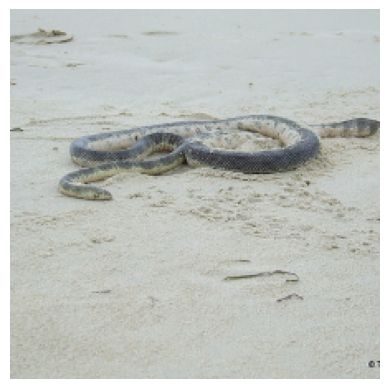

-----------------
alp
alp


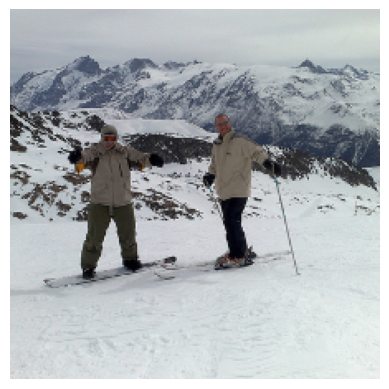

-----------------
Shetland_sheepdog
Shetland sheepdog, Shetland sheep dog, Shetland


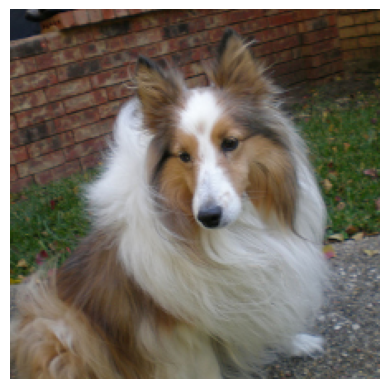

-----------------
soup_bowl
soup bowl


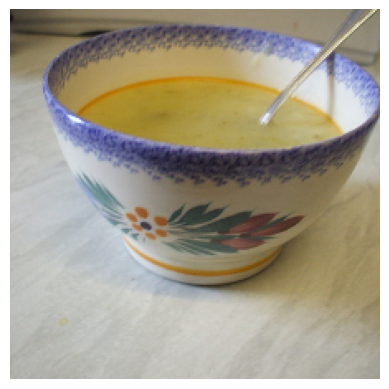

-----------------
cradle
cradle


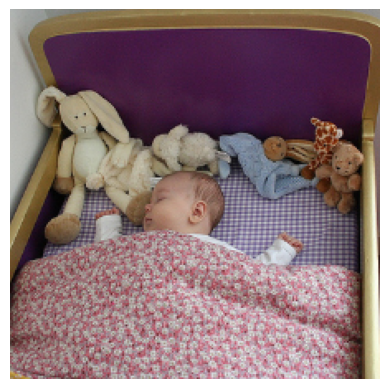

-----------------
garter_snake
garter snake, grass snake


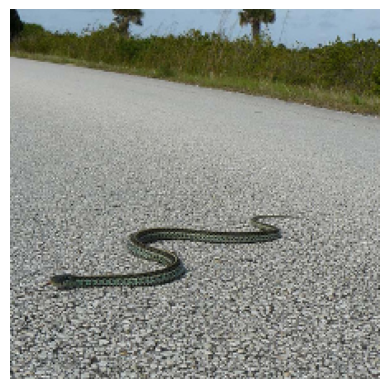

-----------------
porcupine
porcupine, hedgehog


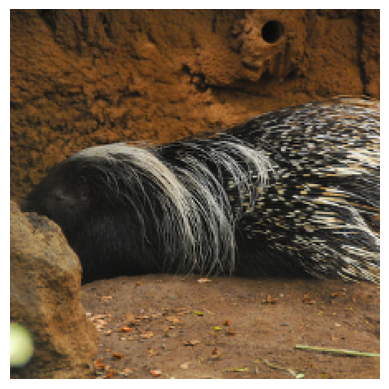

-----------------
bakery
bakery, bakeshop, bakehouse


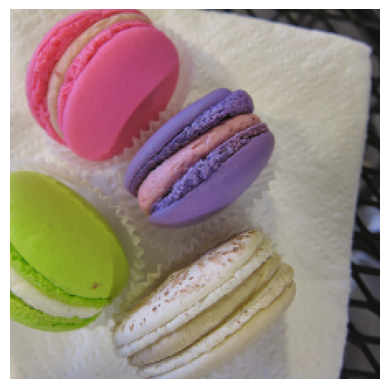

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----------------
mousetrap
mousetrap


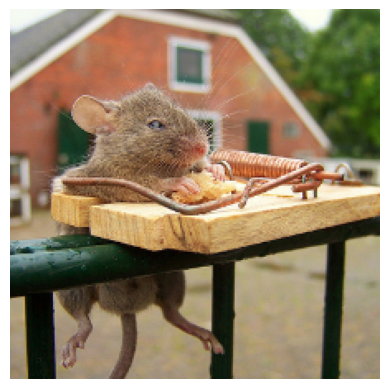

-----------------
Angora
Angora, Angora rabbit


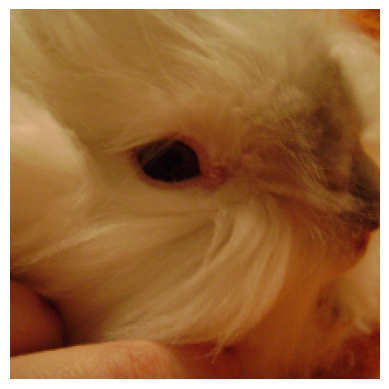

In [19]:
# validate the validation label & class description match our perception
for i in range(10):
    imgfn = os.path.basename(INdataset.samples[i][0])
    # imgfn = INdataset.samples[i][0].split('/')[-1]
    print('-----------------')
    print(label_dict[vallabel_dict[imgfn]])
    print(label_descr_dict[vallabel_dict[imgfn]])
    plt.imshow(denormalizer(INdataset[i][0]).permute(1,2,0))    
    plt.axis('off')
    plt.show()

## Compute ImageNet validation set kNN and their labels

In [31]:
# compute mahalanobis distance for all Exps
stats_df_col = []
for Expi in tqdm(range(1, 190+1)):
    # if ~ os.path.exists(join(Evol_embed_dir, f"Exp{Expi}_embed_act_data.pkl")):
    #     continue
    if Expi not in meta_df.index:
        continue
    meta_dict = meta_df.loc[Expi][['Animal', 'expdate', 'ephysFN', 'prefchan', 'prefunit', 'visual_area',
       'space1', 'space2', 'optim_names1', 'optim_names2', 'blockN']].to_dict()
    Evol_data = pkl.load(open(join(Evol_embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "rb"))
    for thread in [0, 1]:
        stats_col = {}
        embeddings = Evol_data[f"embeddings{thread}"].cuda()
        gen_vec = Evol_data[f"gen_vec{thread}"]
        resp_mat = Evol_data[f"resp_mat{thread}"]
        stats_col["Expi"] = Expi
        stats_col["thread"] = thread
        stats_col["generation"] = gen_vec
        stats_col["resp_mean"] = resp_mat[:, 0]
        for dataset_str in ["imagenet_valid"]: #MH_eig_col:
            data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
            dataset_embed = dataset_embed_col[dataset_str]
            # MHdist_thread = mahalanobis_sqdist(embeddings, data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
            # NLL_thread = gaussian_nll_with_eig(embeddings, data_mean, data_eigvals, data_eigvecs, eigfloor=1e-3).cpu()
            kNNdist, kNN_idxs = dist2k_nearest_neighbor_w_index(embeddings, dataset_embed, k_list=[1, 5, 10, 25, 50])
            KNNMHdist, KNNMH_idxs = dist2k_nearest_neighbor_mahalanobis_w_index(embeddings, dataset_embed, [1, 5, 10, 25, 50],
                                                            data_eigvecs, data_eigvals, eigfloor=1e-3)
            kNNcosdist, kNNcos_idxs = dist2k_nearest_neighbor_cosine_w_index(embeddings, dataset_embed, [1, 5, 10, 25, 50])
            # stats_col[f"MHdist_{dataset_str}"] = MHdist_thread
            # stats_col[f"NLL_{dataset_str}"] = NLL_thread
            for k in kNNdist:
                stats_col[f"kNNdist_{k}_{dataset_str}"] = kNNdist[k].cpu()
                stats_col[f"kNNMHdist_{k}_{dataset_str}"] = KNNMHdist[k].cpu()
                stats_col[f"kNNcosdist_{k}_{dataset_str}"] = kNNcosdist[k].cpu()
            for i in range(50):
                stats_col[f"kNNidx_{i}_{dataset_str}"] = kNN_idxs[:, i].cpu()
                stats_col[f"kNNMHidx_{i}_{dataset_str}"] = KNNMH_idxs[:, i].cpu()
                stats_col[f"kNNcosidx_{i}_{dataset_str}"] = kNNcos_idxs[:, i].cpu()
        stats_col.update(meta_dict)
        stats_df = pd.DataFrame(stats_col)
        stats_df_col.append(stats_df)

stats_df_all = pd.concat(stats_df_col, ignore_index=True)

100%|██████████| 190/190 [00:10<00:00, 17.32it/s]


In [32]:
stats_df_all.to_csv(join(tabdir, "Evol_img_DINO_embed_kNN_indices.csv"))

In [34]:
# add labels computed for each kNN sample
dataset_str = "imagenet_valid"
kNNidxs_df = stats_df_all[[f"kNNcosidx_{i}_{dataset_str}" for i in range(50)]].map(lambda x: vallabel_list[x])
kNNidxs_df.columns = [f"kNNcoslabel_{i}_{dataset_str}" for i in range(50)]

In [35]:
stats_df_all = pd.concat([stats_df_all, kNNidxs_df], axis=1)

In [37]:
stats_df_all.to_csv(join(tabdir, "Evol_img_DINO_embed_kNN_indices_labels.csv"))

## Post Hoc analysis

In [20]:
stats_df_all = pd.read_csv(join(tabdir, "Evol_img_DINO_embed_kNN_indices_labels.csv"), index_col=0)

In [21]:
from neuro_data_analysis.neural_data_utils import get_all_masks
Amsk, Bmsk, V1msk, V4msk, ITmsk, length_msk, spc_msk, \
    sucsmsk, bsl_unstable_msk, bsl_stable_msk, validmsk = get_all_masks(meta_df)
mask_dict = get_all_masks(meta_df, return_type=dict)
FCsucs_msk = meta_df.p_maxinit_0 < 0.05 
BGsucs_msk = meta_df.p_maxinit_1 < 0.05
bothsucs_msk = FCsucs_msk & BGsucs_msk
anysucs_msk = FCsucs_msk | BGsucs_msk

total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3
total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3


In [25]:
# get global flattened df masks instead of the smaller factorized meta_df masks
validexp_mask = stats_df_all.Expi.isin(meta_df[validmsk].index)
init_gen_mask  = (stats_df_all.generation > 1) & \
                 (stats_df_all.generation <= 5)
final_gen_mask = (stats_df_all.generation >= stats_df_all.blockN - 5) & \
                 (stats_df_all.generation <= stats_df_all.blockN - 1)
BigGAN_mask = stats_df_all.thread == 1
DeePSim_mask = stats_df_all.thread == 0
IT_mask = stats_df_all.visual_area == "IT"
V4_mask = stats_df_all.visual_area == "V4"
V1_mask = stats_df_all.visual_area == "V1"
BGsuccess_mask = stats_df_all.Expi.isin(meta_df[BGsucs_msk].index)
FCsuccess_mask = stats_df_all.Expi.isin(meta_df[FCsucs_msk].index)
bothsuccess_mask = stats_df_all.Expi.isin(meta_df[bothsucs_msk].index)
anysuccess_mask = stats_df_all.Expi.isin(meta_df[anysucs_msk].index)

In [22]:
stats_df_all

Expi  thread  generation   resp_mean  kNNdist_1_imagenet_valid  \
0          3       0           1  159.850917                 49.656757   
1          3       0           1  105.139166                 48.584103   
2          3       0           1  114.781936                 44.129807   
3          3       0           1  113.217269                 42.653053   
4          3       0           1  204.278660                 50.152756   
...      ...     ...         ...         ...                       ...   
306047   190       1          19  270.388398                 49.362324   
306048   190       1          19  371.792224                 49.694767   
306049   190       1          19  364.520691                 51.622890   
306050   190       1          19  314.235970                 44.556786   
306051   190       1          19  312.997676                 49.487587   

        kNNMHdist_1_imagenet_valid  kNNcosdist_1_imagenet_valid  \
0                        33.299236                     0.702477   
1                        34.233967                     0.678336   
2                        30.893002                     0.629351   
3                        29.840944                     0.567292   
4                        32.329895                     0.654570   
...                            ...                          ...   
306047                   31.321207                     0.637685   
306048                   33.045734                     0.674464   
306049                   33.341550                     0.673014   
306050                   29.780348                     0.502738   
306051                   33.007545                     0.669821   

        kNNdist_5_imagenet_valid  kNNMHdist_5_imagenet_valid  \
0                      51.799873                   33.556297   
1                      50.716000                   34.993610   
2                      45.854916                   31.348623   
3                      44.982975                   30.611311   
4                      51.948975                   33.660084   
...                          ...                         ...   
306047                 51.034004                   32.571180   
306048                 51.500195                   33.263763   
306049                 52.508247                   34.433956   
306050                 49.823704                   32.530197   
306051                 51.203160                   33.466747   

        kNNcosdist_5_imagenet_valid  ...  kNNcoslabel_40_imagenet_valid  \
0                          0.713107  ...                            189   
1                          0.722378  ...                            314   
2                          0.679475  ...                            740   
3                          0.613542  ...                            585   
4                          0.711423  ...                            917   
...                             ...  ...                            ...   
306047                     0.688971  ...                            674   
306048                     0.708565  ...                            490   
306049                     0.725043  ...                            788   
306050                     0.594464  ...                            691   
306051                     0.707538  ...                            623   

        kNNcoslabel_41_imagenet_valid  kNNcoslabel_42_imagenet_valid  \
0                                 192                            861   
1                                 773                            921   
2                                 424                            842   
3                                 865                            620   
4                                 588                            181   
...                               ...                            ...   
306047                            771                            648   
306048                            499                            788

In [27]:
def get_label_dist_in_mask(stats_df_all, mask, dataset_str="imagenet_valid"):
    ''' 
    Find the label distribution in a mask of rows in stats_df_all. 
        return labels, counts, cnt_vec, freq_vec
    '''
    knn_coslabels = stats_df_all[mask][[f"kNNcoslabel_{i}_{dataset_str}" 
                                             for i in range(50)]].to_numpy()
    labels, counts = np.unique(knn_coslabels, return_counts=True)
    cnt_vec= np.zeros(1000, dtype=int)
    cnt_vec[labels] = counts
    freq_vec = cnt_vec / cnt_vec.sum()
    return labels, counts, cnt_vec, freq_vec


def get_label_dist_in_multimasks(stats_df_all, masks, label_strs, dataset_str="imagenet_valid"):
    """multi masks version of get_label_dist_in_mask"""
    labels_col = {}
    counts_col = {}
    cnt_vec_col = {}
    freq_vec_col = {}
    for mask, label_str in zip(masks, label_strs):
        labels, counts, cnt_vec, freq_vec = get_label_dist_in_mask(stats_df_all, mask, dataset_str=dataset_str)
        labels_col[label_str] = labels
        counts_col[label_str] = counts
        cnt_vec_col[label_str] = cnt_vec
        freq_vec_col[label_str] = freq_vec
    return labels_col, counts_col, cnt_vec_col, freq_vec_col


def print_labels_counts(labels, counts, label_dict=label_descr_dict, topk=30):
    """Print the topk frequent labels and their counts"""
    sorted_indices = np.argsort(-counts)
    sorted_labels = labels[sorted_indices]
    sorted_counts = counts[sorted_indices]
    for label, count in zip(sorted_labels[:topk], sorted_counts[:topk]):
        label_name = label_dict[label]
        print(f"{label_name}: {count}")

In [29]:
masks = [init_gen_mask & BigGAN_mask & IT_mask & BGsuccess_mask & validexp_mask,
        init_gen_mask & BigGAN_mask & IT_mask & ~BGsuccess_mask & validexp_mask,
        init_gen_mask & BigGAN_mask & V4_mask & BGsuccess_mask & validexp_mask,
        init_gen_mask & BigGAN_mask & V4_mask & ~BGsuccess_mask & validexp_mask,
        final_gen_mask & BigGAN_mask & IT_mask & BGsuccess_mask & validexp_mask,
        final_gen_mask & BigGAN_mask & IT_mask & ~BGsuccess_mask & validexp_mask,
        final_gen_mask & BigGAN_mask & V4_mask & BGsuccess_mask & validexp_mask,
        final_gen_mask & BigGAN_mask & V4_mask & ~BGsuccess_mask & validexp_mask,]
label_strs = [
    "init_gen_BigGAN_IT_BGsuccess",
    "init_gen_BigGAN_IT_BGfail",
    "init_gen_BigGAN_V4_BGsuccess",
    "init_gen_BigGAN_V4_BGfail",
    "final_gen_BigGAN_IT_BGsuccess",
    "final_gen_BigGAN_IT_BGfail",
    "final_gen_BigGAN_V4_BGsuccess",
    "final_gen_BigGAN_V4_BGfail",
]
_, _, cnt_vecs, freq_vecs = get_label_dist_in_multimasks(stats_df_all, masks, label_strs)

In [ ]:
# _, _, cnt_vec_ITBGsucs, freq_vec_ITBGsucs = get_label_dist_in_mask(stats_df_all, 
#                 final_gen_mask & BigGAN_mask & IT_mask & BGsuccess_mask)
# _, _, cnt_vec_ITBGfail, freq_vec_ITBGfail = get_label_dist_in_mask(stats_df_all, 
#                 final_gen_mask & BigGAN_mask & IT_mask & ~BGsuccess_mask)

# _, _, cnt_vec_V4BGsucs, freq_vec_V4BGsucs = get_label_dist_in_mask(stats_df_all, 
#                 final_gen_mask & BigGAN_mask & V4_mask & BGsuccess_mask)
# _, _, cnt_vec_V4BGfail, freq_vec_V4BGfail = get_label_dist_in_mask(stats_df_all, 
#                 final_gen_mask & BigGAN_mask & V4_mask & ~BGsuccess_mask)

### Visualize distribution of labels change

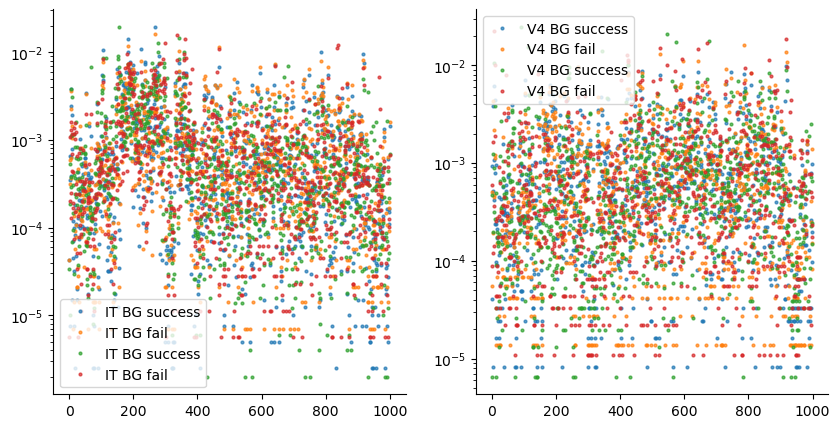

In [30]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.plot(freq_vecs["init_gen_BigGAN_IT_BGsuccess"], "o",markersize=2,
         label="IT BG success", alpha=0.7)
plt.plot(freq_vecs["init_gen_BigGAN_IT_BGfail"], "o",markersize=2,
        label="IT BG fail", alpha=0.7)
plt.plot(freq_vecs["final_gen_BigGAN_IT_BGsuccess"], "o",markersize=2,
         label="IT BG success", alpha=0.7)
plt.plot(freq_vecs["final_gen_BigGAN_IT_BGfail"], "o",markersize=2,
        label="IT BG fail", alpha=0.7)
plt.yscale('log')
plt.legend()
plt.subplot(122)
plt.plot(freq_vecs["init_gen_BigGAN_V4_BGsuccess"], "o", markersize=2,
        label="V4 BG success", alpha=0.7)
plt.plot(freq_vecs["init_gen_BigGAN_V4_BGfail"], "o",markersize=2,
        label="V4 BG fail", alpha=0.7)
plt.plot(freq_vecs["final_gen_BigGAN_V4_BGsuccess"], "o", markersize=2,
        label="V4 BG success", alpha=0.7)
plt.plot(freq_vecs["final_gen_BigGAN_V4_BGfail"], "o", markersize=2,
        label="V4 BG fail", alpha=0.7)
plt.yscale('log')
plt.legend()
plt.show()

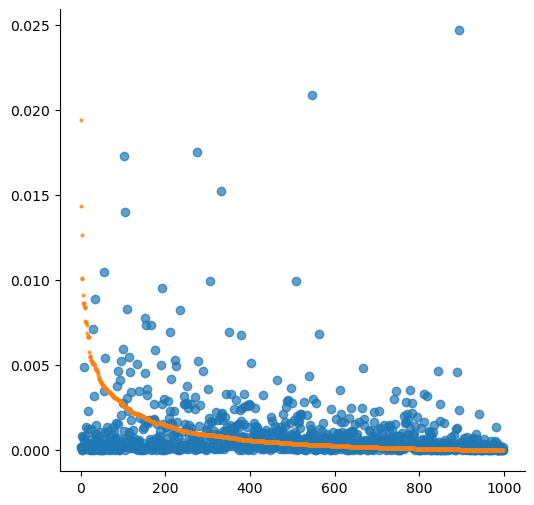

In [31]:
sortidx = np.argsort(freq_vecs["final_gen_BigGAN_IT_BGsuccess"])[::-1]
plt.figure(figsize=[6,6])
plt.plot(freq_vecs["final_gen_BigGAN_V4_BGsuccess"][sortidx], "o", 
         label="V4 BG success", alpha=0.7)
plt.plot(freq_vecs["final_gen_BigGAN_IT_BGsuccess"][sortidx], "o",markersize=2,
         label="IT BG success", alpha=0.7)
plt.show()

In [108]:
np.argsort([5, 0, 3, 2, 1])[::-1]

array([0, 2, 3, 4, 1])

### Test for Statistical changes in label distribution

In [33]:
from scipy.stats import chi2_contingency
def test_print_difference(cnt1, cnt2, offset=1, topN=10):
    # global contingency table of the two vectors. 
    chi2_stat, p_value, dof, expected = chi2_contingency(
        np.stack([cnt1, cnt2], axis=0) + offset)
    print(f"Chi2 test p-value: {p_value} chi2={chi2_stat} dof={dof}")
    change_ratio = (cnt2 + 1) / (cnt1 + 1)
    sort_idx = np.argsort(change_ratio)[::-1]
    print(f"Top {topN} freq increased labels")
    for i in range(topN):
        print(f"{i+1}: {label_dict[sort_idx[i]]} {change_ratio[sort_idx[i]]:.1f} | {cnt1[sort_idx[i]]}->{cnt2[sort_idx[i]]}")
    print()
    print(f"Top {topN} freq decreased labels")
    for i in range(topN):
        print(f"{i+1}: {label_dict[sort_idx[-i-1]]} {change_ratio[sort_idx[-i-1]]:.1f} | {cnt1[sort_idx[-i-1]]}->{cnt2[sort_idx[-i-1]]}")
        
    
def test_print_per_class_difference(cnt1, cnt2, offset=1, ):
    chi2_all, p_val_all, dof_all, _ = chi2_contingency(
        np.stack([cnt1, cnt2], axis=0) + offset)
    print(f"Chi2 test p-value: {p_val_all:.1e} chi2={chi2_all:.2f} dof={dof_all}")
    n_classes = cnt1.shape[0]
    sum_cnt1 = cnt1.sum()
    sum_cnt2 = cnt2.sum()
    df_col = []
    for label in range(n_classes):
        # build 2x2 contingency table for each class 
        cont_max_class = np.array([[cnt1[label], sum_cnt1 - cnt1[label]],
                                   [cnt2[label], sum_cnt2 - cnt2[label]]])
        try:
            chi2_class, p_class, dof, expected = chi2_contingency(cont_max_class)
        except ValueError:
            # chi2 will throw an error if any of the values in the table are 0.
            # in that case, we can just skip this class as nan. (other handling methods e.g. adding offset?)
            chi2_class, p_class, dof = np.nan, np.nan, np.nan
        df_col.append({
            "label": label,
            "label_name": label_dict[label],
            "p_value": p_class,
            "chi2": chi2_class,
            "dof": dof,
            "cnt1": cnt1[label],
            "cnt2": cnt2[label],
            "ratio": (cnt2[label] / sum_cnt2) / (cnt1[label] / sum_cnt1),
        })
    chi2_df = pd.DataFrame(df_col)
    return chi2_df, chi2_all, p_val_all, dof_all

* We are inspired by the volcano plot https://training.galaxyproject.org/training-material/topics/transcriptomics/tutorials/rna-seq-viz-with-volcanoplot/tutorial.html

In [36]:
chi2_df, chi2_all, p_val_all, dof_all = test_print_per_class_difference(
    cnt_vecs["final_gen_BigGAN_IT_BGfail"], 
    cnt_vecs["final_gen_BigGAN_IT_BGsuccess"], offset=1)

Chi2 test p-value: 0.0e+00 chi2=127545.27 dof=999


/tmp/ipykernel_1148372/1258670733.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  "ratio": (cnt2[label] / sum_cnt2) / (cnt1[label] / sum_cnt1),
/tmp/ipykernel_1148372/1258670733.py:42: RuntimeWarning: invalid value encountered in double_scalars
  "ratio": (cnt2[label] / sum_cnt2) / (cnt1[label] / sum_cnt1),


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


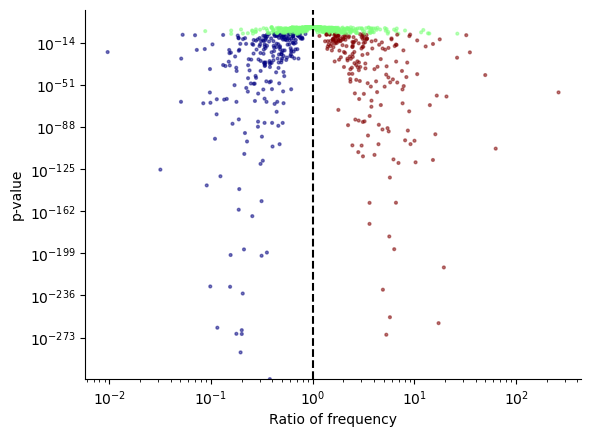

In [37]:
plt.scatter(chi2_df.ratio, chi2_df.p_value, 
            c=(chi2_df.p_value < 1E-6) * (np.sign(np.log(chi2_df.ratio))), 
            s=4, alpha=0.5, cmap="jet")
plt.axvline(1, color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Ratio of frequency")
plt.ylabel("p-value")
plt.show()

In [38]:
print("Most significant increased labels")
chi2_df[chi2_df.ratio > 1].sort_values(by="p_value").head(25)

Most significant increased labels


label         label_name        p_value         chi2  dof  cnt1  cnt2  \
342    342          wild_boar   0.000000e+00  1468.889491  1.0   970  8288   
277    277            red_fox   0.000000e+00  1768.622025  1.0   354  6353   
154    154           Pekinese   0.000000e+00  1912.433993  1.0  1043  9851   
278    278            kit_fox  3.095349e-271  1238.166737  1.0   379  5084   
682    682            obelisk  4.429378e-261  1191.436727  1.0    79  3462   
151    151          Chihuahua  7.539174e-256  1167.367543  1.0   316  4601   
116    116             chiton  1.197167e-231  1056.018664  1.0   365  4532   
157    157           papillon  4.497828e-212   965.962118  1.0    56  2765   
156    156   Blenheim_spaniel  4.993066e-196   892.149804  1.0   210  3370   
263    263           Pembroke  7.808078e-185   840.658027  1.0   233  3344   
152    152   Japanese_spaniel  9.210257e-174   789.733174  1.0   459  4209   
259    259         Pomeranian  2.847709e-155   704.696172  1.0   409  3755   
670    670      motor_scooter  3.681644e-155   704.183209  1.0   157  2620   
264    264           Cardigan  5.251725e-133   602.314852  1.0   164  2385   
144    144            pelican  3.334040e-120   543.458853  1.0   112  1979   
931    931              bagel  1.282785e-119   540.768929  1.0    67  1744   
231    231             collie  1.451325e-117   531.329247  1.0    41  1581   
249    249           malamute  4.640719e-117   529.008822  1.0   128  2019   
306    306  rhinoceros_beetle  2.306088e-114   516.615562  1.0   402  3178   
284    284        Siamese_cat  4.330213e-113   510.761615  1.0   243  2495   
69      69          trilobite  1.175152e-110   499.576599  1.0   487  3464   
533    533            dishrag  1.428497e-107   485.399310  1.0     8  1278   
343    343            warthog  6.983526e-105   473.040791  1.0   392  3007   
294    294         brown_bear  1.049118e-104   472.228541  1.0   631  3926   
777    777           scabbard  1.040044e-103   467.650444  1.0   191  2146   

         ratio  
342   3.375191  
277   7.089179  
154   3.730924  
278   5.298912  
682  17.310926  
151   5.751558  
116   4.904756  
157  19.504169  
156   6.339149  
263   5.669316  
152   3.622318  
259   3.626661  
670   6.592072  
264   5.744667  
144   6.979882  
931  10.282341  
231  15.232400  
249   6.230841  
306   3.122829  
284   4.055875  
69    2.809760  
533  63.104627  
343   3.030175  
294   2.457770  
777   4.438300

In [39]:
print("Most significant decreased labels")
chi2_df[chi2_df.ratio < 1].sort_values(by="p_value").head(25)

Most significant decreased labels


label               label_name        p_value         chi2  dof  cnt1  \
467    467             butcher_shop   0.000000e+00  1933.505871  1.0  2280   
583    583               guillotine   0.000000e+00  1971.579951  1.0  1023   
298    298                 mongoose   0.000000e+00  1556.820083  1.0  2305   
360    360                    otter   0.000000e+00  2878.732560  1.0  2610   
383    383           Madagascar_cat   0.000000e+00  1665.511497  1.0  1133   
420    420                    banjo   0.000000e+00  2076.550986  1.0   950   
462    462                    broom   0.000000e+00  2190.326936  1.0  1256   
292    292                    tiger   0.000000e+00  2024.682451  1.0  1490   
836    836                 sunglass   0.000000e+00  2993.212231  1.0  2106   
967    967                 espresso   0.000000e+00  1669.334828  1.0   917   
837    837               sunglasses   0.000000e+00  4371.300555  1.0  2186   
181    181       Bedlington_terrier   0.000000e+00  3047.372160  1.0  1785   
188    188  wire-haired_fox_terrier   0.000000e+00  1783.069091  1.0  1415   
337    337                   beaver  2.724284e-310  1417.888431  1.0  2830   
175    175               otterhound  8.590999e-287  1309.751714  1.0  1194   
267    267          standard_poodle  1.334920e-270  1235.245983  1.0  1152   
265    265               toy_poodle  1.972933e-270  1234.465314  1.0  1045   
191    191                 Airedale  3.104505e-267  1219.755106  1.0  1137   
840    840                     swab  4.434701e-265  1209.839703  1.0   790   
365    365                orangutan  5.250049e-235  1071.468289  1.0  1018   
190    190         Sealyham_terrier  4.443432e-229  1044.196622  1.0   802   
289    289             snow_leopard  8.720957e-229  1042.849307  1.0   634   
286    286                   cougar  8.681326e-202   918.645375  1.0  1385   
792    792                   shovel  3.911654e-201   915.637905  1.0   709   
643    643                     mask  5.632896e-199   905.709117  1.0  1626   

     cnt2     ratio  
467  1487  0.257630  
583   160  0.061782  
298  1815  0.311047  
360  1289  0.195089  
383   360  0.125514  
420    79  0.032849  
462   271  0.085231  
292   545  0.144488  
836   715  0.134112  
967   174  0.074955  
837   298  0.053850  
181   409  0.090512  
188   582  0.162475  
337  2717  0.379248  
175   591  0.195526  
267   586  0.200940  
265   470  0.177665  
191   578  0.200811  
840   231  0.115506  
365   529  0.205271  
190   313  0.154167  
289   158  0.098444  
286  1103  0.314591  
792   280  0.156003  
643  1460  0.354693

### BigGAN fail vs BigGAN success driven by IT (final gens)

Chi2 test p-value: 0.0e+00 chi2=117462.06 dof=999


/tmp/ipykernel_3319669/4060284021.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  "ratio": (cnt2[label] / sum_cnt2) / (cnt1[label] / sum_cnt1),
/tmp/ipykernel_3319669/4060284021.py:42: RuntimeWarning: invalid value encountered in double_scalars
  "ratio": (cnt2[label] / sum_cnt2) / (cnt1[label] / sum_cnt1),


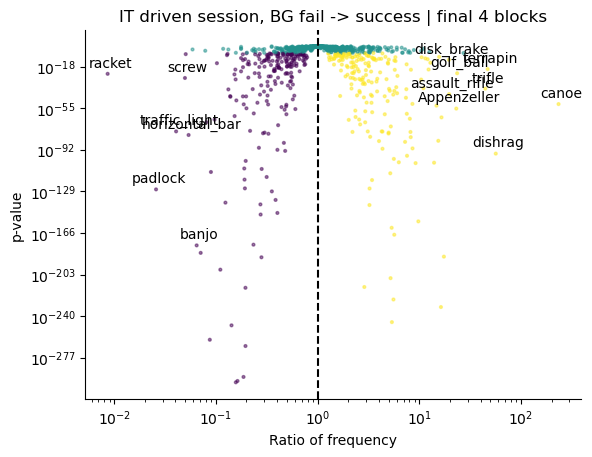

In [65]:
chi2_df, chi2_all, p_val_all, dof_all = test_print_per_class_difference(
                      cnt_vecs["final_gen_BigGAN_IT_BGfail"], 
                      cnt_vecs["final_gen_BigGAN_IT_BGsuccess"])

plt.scatter(chi2_df.ratio, chi2_df.p_value, 
            c=(chi2_df.p_value < 1E-6) * (np.sign(np.log(chi2_df.ratio))), 
            s=4, alpha=0.5)

plt.xscale('log')
plt.yscale('log')

# Annotating points
top_points = chi2_df[chi2_df.p_value < 1E-10].sort_values(by='ratio', ascending=False).head(8)
bot_points = chi2_df[chi2_df.p_value < 1E-10].sort_values(by='ratio', ascending=True).head(8)
for _, row in pd.concat([top_points, bot_points]).iterrows():
    plt.annotate(row['label_name'], 
                 xy=(row['ratio'], row['p_value']),
                xycoords='data', 
                textcoords="offset points", 
                xytext=(2,5),
                 ha='center')

plt.axvline(1, color='k', linestyle='--')
plt.xlabel("Ratio of frequency")
plt.ylabel("p-value")
plt.title("IT driven session, BG fail -> success | final 4 blocks")
plt.show()

In [39]:
print("Most significant increased labels in IT driven session, BG fail -> success | final 4 blocks")
chi2_df[chi2_df.ratio > 1].sort_values(by="p_value").head(25)

Most significant increased labels in IT driven session, BG fail -> success | final 4 blocks


label        label_name        p_value         chi2  dof  cnt1  cnt2  \
154    154          Pekinese   0.000000e+00  1536.368605  1.0  1042  9733   
277    277           red_fox   0.000000e+00  1596.951654  1.0   312  6334   
278    278           kit_fox  4.334230e-246  1122.462137  1.0   333  5065   
682    682           obelisk  1.081889e-232  1060.821804  1.0    75  3462   
151    151         Chihuahua  5.769251e-226  1029.872667  1.0   290  4569   
342    342         wild_boar  7.346860e-215   978.783113  1.0   884  7202   
116    116            chiton  5.606429e-207   942.520144  1.0   293  4326   
157    157          papillon  7.697006e-188   854.485916  1.0    56  2765   
156    156  Blenheim_spaniel  2.447679e-168   764.784528  1.0   210  3370   
263    263          Pembroke  3.694283e-162   736.367977  1.0   221  3343   
670    670     motor_scooter  1.829601e-156   710.178448  1.0    93  2574   
152    152  Japanese_spaniel  6.185503e-142   643.368353  1.0   459  4200   
259    259        Pomeranian  3.272651e-127   575.674828  1.0   409  3752   
69      69         trilobite  1.050732e-119   541.167288  1.0   345  3347   
264    264          Cardigan  1.138457e-113   513.428314  1.0   162  2375   
931    931             bagel  1.235710e-104   471.901839  1.0    67  1743   
231    231            collie  2.890398e-104   470.205926  1.0    40  1581   
144    144           pelican  7.038039e-104   468.429824  1.0   111  1975   
249    249          malamute  6.837633e-101   454.701707  1.0   127  2019   
102    102           echidna   4.074693e-98   441.949808  1.0    81  1735   
533    533           dishrag   3.480765e-96   433.074749  1.0     8  1278   
284    284       Siamese_cat   7.531758e-92   413.157177  1.0   173  2127   
217    217  English_springer   1.522637e-91   411.752766  1.0    64  1553   
283    283       Persian_cat   9.535341e-86   385.124317  1.0    75  1537   
777    777          scabbard   4.986185e-85   381.824376  1.0   183  2079   

         ratio  
154   3.304666  
277   7.182440  
278   5.381257  
682  16.331058  
151   5.574060  
342   2.882368  
116   5.223570  
157  17.468500  
156   5.677526  
263   5.351711  
670   9.792061  
152   3.237316  
259   3.245548  
69    3.432299  
264   5.186772  
931   9.203883  
231  13.983645  
144   6.294955  
249   5.624464  
102   7.578146  
533  56.518338  
284   4.349806  
217   8.584994  
283   7.250386  
777   4.019314

In [40]:
print("Most significant decreased labels in IT driven session, BG fail -> success | final 4 blocks")
chi2_df[chi2_df.ratio < 1].sort_values(by="p_value").head(25)

Most significant decreased labels in IT driven session, BG fail -> success | final 4 blocks


label               label_name        p_value         chi2  dof  cnt1  \
360    360                    otter   0.000000e+00  3421.179736  1.0  2524   
188    188  wire-haired_fox_terrier   0.000000e+00  1908.733540  1.0  1346   
181    181       Bedlington_terrier   0.000000e+00  3270.491582  1.0  1692   
175    175               otterhound   0.000000e+00  1479.653125  1.0  1163   
836    836                 sunglass   0.000000e+00  3202.576822  1.0  1997   
286    286                   cougar   0.000000e+00  1462.789907  1.0  1335   
462    462                    broom   0.000000e+00  2089.209654  1.0  1062   
467    467             butcher_shop   0.000000e+00  2531.157732  1.0  1942   
837    837               sunglasses   0.000000e+00  4834.106449  1.0  2133   
383    383           Madagascar_cat   0.000000e+00  1959.243715  1.0  1130   
298    298                 mongoose   0.000000e+00  2131.193642  1.0  2251   
337    337                   beaver   0.000000e+00  2018.327230  1.0  2771   
292    292                    tiger   0.000000e+00  2492.871815  1.0  1483   
967    967                 espresso   0.000000e+00  1877.007480  1.0   910   
365    365                orangutan  1.189184e-299  1368.924528  1.0   984   
265    265               toy_poodle  1.846193e-298  1363.443648  1.0  1006   
267    267          standard_poodle  7.379743e-295  1346.869124  1.0  1101   
191    191                 Airedale  2.371364e-267  1220.293444  1.0  1035   
289    289             snow_leopard  9.009097e-262  1194.619283  1.0   633   
190    190         Sealyham_terrier  5.770662e-249  1135.693464  1.0   767   
266    266         miniature_poodle  1.513459e-215   981.939650  1.0   833   
843    843                    swing  2.002205e-199   907.775592  1.0   534   
223    223               schipperke  2.025441e-188   857.152894  1.0  1050   
840    840                     swab  1.756877e-184   839.038024  1.0   414   
420    420                    banjo  7.955390e-178   808.423459  1.0   388   

     cnt2     ratio  
360  1171  0.164141  
188   582  0.152977  
181   395  0.082593  
175   585  0.177961  
836   706  0.125076  
286   803  0.212805  
462   235  0.078287  
467   949  0.172888  
837   287  0.047604  
383   341  0.106764  
298  1574  0.247387  
337  2413  0.308084  
292   478  0.114034  
967   174  0.067648  
365   437  0.157121  
265   464  0.163181  
267   582  0.187018  
191   572  0.195526  
289   156  0.087191  
190   309  0.142532  
266   460  0.195372  
843   167  0.110643  
223   833  0.280675  
840    83  0.070929  
420    71  0.064740

### BigGAN success driven by IT (initial gens -> final gens)

Chi2 test p-value: 0.0e+00 chi2=191273.86 dof=999


/tmp/ipykernel_3319669/4060284021.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  "ratio": (cnt2[label] / sum_cnt2) / (cnt1[label] / sum_cnt1),
/tmp/ipykernel_3319669/4060284021.py:42: RuntimeWarning: invalid value encountered in double_scalars
  "ratio": (cnt2[label] / sum_cnt2) / (cnt1[label] / sum_cnt1),
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


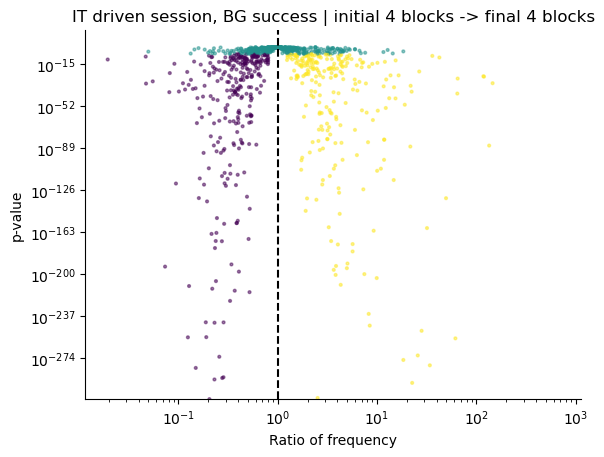

In [41]:
chi2_df, chi2_all, p_val_all, dof_all = test_print_per_class_difference(
                      cnt_vecs["init_gen_BigGAN_IT_BGsuccess"], 
                      cnt_vecs["final_gen_BigGAN_IT_BGsuccess"])

plt.scatter(chi2_df.ratio, chi2_df.p_value, 
            c=(chi2_df.p_value < 1E-6) * (np.sign(np.log(chi2_df.ratio))), 
            s=4, alpha=0.5)
plt.axvline(1, color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Ratio of frequency")
plt.ylabel("p-value")
plt.title("IT driven session, BG success | initial 4 blocks -> final 4 blocks")
plt.show()

In [42]:
print("Most significant increased labels in IT driven session, BG success | initial 4 blocks -> final 4 blocks")
chi2_df[chi2_df.ratio > 1].sort_values(by="p_value").head(25)

Most significant increased labels in IT driven session, BG success | initial 4 blocks -> final 4 blocks


label           label_name        p_value         chi2  dof  cnt1  cnt2  \
259    259           Pomeranian   0.000000e+00  2744.732809  1.0    99  3752   
116    116               chiton   0.000000e+00  2421.397473  1.0   432  4326   
295    295  American_black_bear   0.000000e+00  1583.222141  1.0   479  3345   
294    294           brown_bear   0.000000e+00  1530.244945  1.0   685  3769   
279    279           Arctic_fox   0.000000e+00  1770.967037  1.0   561  3803   
152    152     Japanese_spaniel   0.000000e+00  3359.895982  1.0     5  4200   
342    342            wild_boar   0.000000e+00  1520.629032  1.0  2367  7202   
155    155             Shih-Tzu   0.000000e+00  1571.598843  1.0    77  2218   
156    156     Blenheim_spaniel   0.000000e+00  2665.252977  1.0    14  3370   
154    154             Pekinese   0.000000e+00  7762.925654  1.0    38  9733   
682    682              obelisk   0.000000e+00  2649.112085  1.0    47  3462   
204    204                Lhasa   0.000000e+00  1747.756652  1.0   108  2536   
244    244      Tibetan_mastiff   0.000000e+00  1549.482819  1.0   107  2284   
260    260                 chow   0.000000e+00  1593.800086  1.0   251  2760   
157    157             papillon   0.000000e+00  2134.162478  1.0    30  2765   
69      69            trilobite   0.000000e+00  1642.982490  1.0   448  3347   
277    277              red_fox  4.707679e-310  1416.795223  1.0  2006  6334   
200    200      Tibetan_terrier  9.582003e-297  1355.550753  1.0    68  1919   
931    931                bagel  2.991201e-281  1284.250405  1.0    41  1743   
256    256         Newfoundland  1.549261e-276  1262.557357  1.0    80  1840   
102    102              echidna  1.517756e-272  1244.192396  1.0    54  1735   
283    283          Persian_cat  1.720136e-257  1174.921693  1.0    20  1537   
231    231               collie  8.094168e-251  1144.219624  1.0    45  1581   
144    144              pelican  3.072456e-246  1123.149660  1.0   187  1975   
153    153          Maltese_dog  6.375357e-236  1075.681137  1.0   185  1908   

          ratio  
259   30.319192  
116    8.011111  
295    5.586639  
294    4.401752  
279    5.423173  
152  672.000000  
342    2.434136  
155   23.044156  
156  192.571429  
154  204.905263  
682   58.927660  
204   18.785185  
244   17.076636  
260    8.796813  
157   73.733333  
69     5.976786  
277    2.526022  
200   22.576471  
931   34.009756  
256   18.400000  
102   25.703704  
283   61.480000  
231   28.106667  
144    8.449198  
153    8.250811

In [43]:
print("Most significant decreased labels in IT driven session, BG success | initial 4 blocks -> final 4 blocks")
chi2_df[chi2_df.ratio < 1].sort_values(by="p_value").head(25)

Most significant decreased labels in IT driven session, BG success | initial 4 blocks -> final 4 blocks


label               label_name        p_value         chi2  dof  cnt1  \
523    523                   crutch   0.000000e+00  1658.124847  1.0  1808   
184    184            Irish_terrier   0.000000e+00  1503.410445  1.0  4046   
191    191                 Airedale   0.000000e+00  2332.863599  1.0  3055   
225    225                 malinois   0.000000e+00  1725.067503  1.0  4356   
237    237       miniature_pinscher   0.000000e+00  1907.646044  1.0  2935   
268    268         Mexican_hairless   0.000000e+00  4662.456529  1.0  7734   
785    785                seat_belt   0.000000e+00  1819.516530  1.0  3998   
188    188  wire-haired_fox_terrier  4.649500e-311  1421.422008  1.0  2262   
189    189         Lakeland_terrier  1.006393e-293  1341.647395  1.0  2337   
467    467             butcher_shop  1.968137e-292  1335.705227  1.0  2742   
198    198       standard_schnauzer  9.054792e-292  1332.655097  1.0  2820   
639    639      maillot (tank suit)  1.512648e-283  1294.816190  1.0  1701   
196    196      miniature_schnauzer  1.046396e-273  1249.537048  1.0  2402   
792    792                   shovel  1.456577e-256  1170.652785  1.0  1414   
171    171        Italian_greyhound  2.085590e-256  1169.935471  1.0  1772   
731    731                  plunger  1.044622e-243  1111.502199  1.0  1940   
178    178               Weimaraner  2.142178e-243  1110.067153  1.0  2357   
181    181       Bedlington_terrier  2.549719e-243  1109.719146  1.0  1669   
150    150                 sea_lion  1.831231e-224  1022.964152  1.0  2589   
182    182           Border_terrier  9.383219e-217   987.495310  1.0  5645   
643    643                     mask  1.835800e-215   981.553877  1.0  2885   
424    424               barbershop  1.014999e-213   973.536908  1.0  1630   
423    423             barber_chair  2.328474e-211   962.677110  1.0  1177   
456    456                      bow  5.156215e-207   942.687390  1.0  1693   
235    235          German_shepherd  1.115948e-198   904.343291  1.0  3099   

     cnt2     ratio  
523   214  0.094690  
184  1763  0.348591  
191   572  0.149787  
225  1810  0.332415  
237   721  0.196525  
268  2127  0.220016  
785  1478  0.295748  
188   582  0.205836  
189   676  0.231408  
467   949  0.276878  
198  1005  0.285106  
639   319  0.150029  
196   777  0.258784  
792   221  0.125035  
171   424  0.191422  
731   562  0.231753  
178   842  0.285787  
181   395  0.189335  
150  1075  0.332175  
182  3680  0.521523  
643  1335  0.370191  
424   448  0.219877  
423   189  0.128462  
456   507  0.239575  
235  1579  0.407615

### BigGAN success driven by V4 vs by IT (final gens)

Chi2 test p-value: 0.0e+00 chi2=249249.95 dof=999


/tmp/ipykernel_3319669/4060284021.py:42: RuntimeWarning: divide by zero encountered in double_scalars
  "ratio": (cnt2[label] / sum_cnt2) / (cnt1[label] / sum_cnt1),
/tmp/ipykernel_3319669/4060284021.py:42: RuntimeWarning: invalid value encountered in double_scalars
  "ratio": (cnt2[label] / sum_cnt2) / (cnt1[label] / sum_cnt1),
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


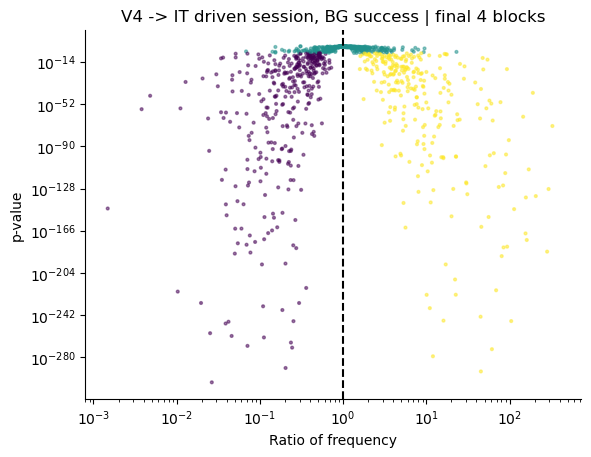

In [44]:
chi2_df, chi2_all, p_val_all, dof_all = test_print_per_class_difference(
                      cnt_vecs["final_gen_BigGAN_V4_BGsuccess"], 
                      cnt_vecs["final_gen_BigGAN_IT_BGsuccess"])

plt.scatter(chi2_df.ratio, chi2_df.p_value, 
            c=(chi2_df.p_value < 1E-6) * (np.sign(np.log(chi2_df.ratio))), 
            s=4, alpha=0.5)
plt.axvline(1, color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Ratio of frequency")
plt.ylabel("p-value")
plt.title("V4 -> IT driven session, BG success | final 4 blocks")
plt.show()

In [45]:
print("Most significant increased labels V4 -> IT driven session, BG success | final 4 blocks")
chi2_df[chi2_df.ratio > 1].sort_values(by="p_value").head(25)

Most significant increased labels V4 -> IT driven session, BG success | final 4 blocks


label           label_name        p_value         chi2  dof  cnt1  cnt2  \
154    154             Pekinese   0.000000e+00  2961.093438  1.0    30  9733   
342    342            wild_boar   0.000000e+00  2162.021512  1.0    31  7202   
278    278              kit_fox   0.000000e+00  1553.600805  1.0     5  5065   
277    277              red_fox   0.000000e+00  1949.880487  1.0     5  6334   
151    151            Chihuahua  2.344456e-293  1339.957293  1.0    31  4569   
359    359  black-footed_ferret  1.033028e-279  1277.171945  1.0   129  5044   
152    152     Japanese_spaniel  2.465252e-273  1247.824534  1.0    21  4200   
259    259           Pomeranian  4.818182e-248  1131.452808  1.0    11  3752   
106    106               wombat  1.183830e-247  1129.656508  1.0    81  4242   
279    279           Arctic_fox  4.176843e-244  1113.333925  1.0    26  3803   
358    358              polecat  2.190949e-236  1077.815369  1.0   121  4342   
341    341                  hog  2.032189e-224  1022.756105  1.0   128  4208   
182    182       Border_terrier  2.528820e-224  1022.319252  1.0    50  3680   
156    156     Blenheim_spaniel  2.573908e-220  1003.881391  1.0    15  3370   
682    682              obelisk  1.278257e-210   959.274905  1.0    48  3462   
263    263             Pembroke  4.753619e-197   896.848021  1.0    60  3343   
187    187    Yorkshire_terrier  1.432386e-189   862.444816  1.0    11  2884   
157    157             papillon  1.536741e-185   843.905171  1.0     3  2765   
260    260                 chow  1.008574e-181   826.347717  1.0    10  2760   
280    280             grey_fox  4.493185e-181   823.363278  1.0     9  2743   
343    343              warthog  4.674878e-175   795.687082  1.0     5  2624   
204    204                Lhasa  3.865991e-169   768.470746  1.0     5  2536   
294    294           brown_bear  6.786045e-164   744.351400  1.0   206  3769   
193    193   Australian_terrier  3.130630e-163   741.297598  1.0    17  2536   
201    201        silky_terrier  2.283939e-154   700.538129  1.0    13  2375   

          ratio  
154   99.564122  
342   71.296600  
278  310.875749  
277  388.763473  
151   45.231070  
359   11.999489  
152   61.377246  
259  104.676102  
106   16.071745  
279   44.888012  
358   11.012397  
341   10.088885  
182   22.586826  
156   68.947106  
682   22.134169  
263   17.098678  
187   80.459989  
157  282.846806  
260   84.700599  
280   93.532102  
343  161.053892  
204  155.652695  
294    5.614826  
193   45.780204  
201   56.065753

In [46]:
print("Most significant decreased labels V4 -> IT driven session, BG success | final 4 blocks")
chi2_df[chi2_df.ratio < 1].sort_values(by="p_value").head(25)

Most significant decreased labels V4 -> IT driven session, BG success | final 4 blocks


label            label_name        p_value          chi2  dof  cnt1  \
545    545          electric_fan   0.000000e+00   9689.265251  1.0  3209   
639    639   maillot (tank suit)   0.000000e+00   2147.379289  1.0  1046   
575    575              golfcart   0.000000e+00   4196.628764  1.0  2664   
113    113                 snail   0.000000e+00   5834.840683  1.0  2345   
660    660           mobile_home   0.000000e+00   2151.877591  1.0   716   
864    864             tow_truck   0.000000e+00   2172.188385  1.0   703   
62      62           rock_python   0.000000e+00   1426.979994  1.0   534   
61      61       boa_constrictor   0.000000e+00   1447.337513  1.0   510   
678    678            neck_brace   0.000000e+00   6647.272480  1.0  2700   
561    561              forklift   0.000000e+00   2720.308784  1.0  1048   
90      90              lorikeet   0.000000e+00  12316.846007  1.0  3796   
506    506                  coil   0.000000e+00   1501.682400  1.0   543   
239    239  Bernese_mountain_dog   0.000000e+00   2078.087249  1.0  1269   
751    751                 racer   0.000000e+00   1996.347386  1.0   748   
344    344          hippopotamus   0.000000e+00   2958.456116  1.0  2157   
766    766            rotisserie   0.000000e+00   2063.109643  1.0  1067   
837    837            sunglasses   0.000000e+00   1498.975160  1.0   793   
423    423          barber_chair   0.000000e+00   4111.298590  1.0  1529   
843    843                 swing   0.000000e+00   1495.326894  1.0   672   
424    424            barbershop   0.000000e+00   3213.070662  1.0  1534   
240    240           Appenzeller   0.000000e+00   2179.858875  1.0  1466   
612    612            jinrikisha  3.566047e-303   1385.137072  1.0   488   
836    836              sunglass  2.921949e-290   1325.712059  1.0  1065   
467    467          butcher_shop  5.855870e-272   1241.494140  1.0  1194   
799    799          sliding_door  2.293008e-270   1234.164871  1.0   541   

     cnt2     ratio  
545   163  0.015588  
639   319  0.093591  
575  1320  0.152061  
113   413  0.054049  
660    36  0.015430  
864    23  0.010040  
62     67  0.038504  
61     44  0.026476  
678   496  0.056376  
561   153  0.044803  
90     23  0.001859  
506    56  0.031649  
239   590  0.142682  
751    95  0.038976  
344  1283  0.182538  
766   370  0.106418  
837   287  0.111067  
423   189  0.037934  
843   167  0.076265  
424   448  0.089625  
240   784  0.164119  
612    42  0.026412  
836   706  0.203438  
467   949  0.243915  
799   125  0.070907

### BigGAN success driven by V4 (initial gens -> final gens)

Chi2 test p-value: 0.0e+00 chi2=71307.47 dof=999


/tmp/ipykernel_3175553/2918651089.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  "ratio": (cnt2[label]) / sum_cnt2 / (cnt1[label] / sum_cnt1),
/tmp/ipykernel_3175553/2918651089.py:39: RuntimeWarning: invalid value encountered in double_scalars
  "ratio": (cnt2[label]) / sum_cnt2 / (cnt1[label] / sum_cnt1),
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


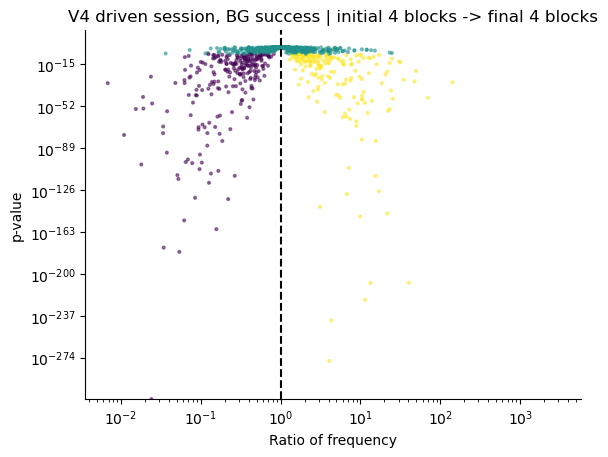

In [157]:
chi2_df, chi2_all, p_val_all, dof_all = test_print_per_class_difference(
                      cnt_vecs["init_gen_BigGAN_V4_BGsuccess"], 
                      cnt_vecs["final_gen_BigGAN_V4_BGsuccess"])

plt.scatter(chi2_df.ratio, chi2_df.p_value, 
            c=(chi2_df.p_value < 1E-6) * (np.sign(np.log(chi2_df.ratio))), 
            s=4, alpha=0.5)
plt.axvline(1, color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Ratio of frequency")
plt.ylabel("p-value")
plt.title("V4 driven session, BG success | initial 4 blocks -> final 4 blocks")
plt.show()

In [158]:
print("Most significant increased labels in V4 driven session, BG success | initial 4 blocks -> final 4 blocks")
chi2_df[chi2_df.ratio > 1].sort_values(by="p_value").head(25)

Most significant increased labels in V4 driven session, BG success | initial 4 blocks -> final 4 blocks


label                  label_name        p_value         chi2  dof  cnt1  \
90      90                    lorikeet   0.000000e+00  3069.741232  1.0     1   
113    113                       snail   0.000000e+00  1681.761765  1.0    77   
545    545                electric_fan   0.000000e+00  1919.688810  1.0   273   
575    575                    golfcart  2.303557e-277  1266.366167  1.0   641   
678    678                  neck_brace  1.127860e-241  1102.146962  1.0   503   
561    561                    forklift  1.816685e-223  1018.379415  1.0   114   
240    240                 Appenzeller  1.491712e-208   949.765651  1.0    88   
239    239        Bernese_mountain_dog  1.798727e-208   949.391735  1.0    25   
241    241                 EntleBucher  4.119041e-150   680.966266  1.0    91   
864    864                   tow_truck  2.342030e-147   668.298681  1.0    35   
344    344                hippopotamus  1.715314e-141   641.331568  1.0   554   
238    238  Greater_Swiss_Mountain_dog  3.012719e-130   589.631979  1.0   134   
569    569               garbage_truck  7.964712e-128   578.496285  1.0    40   
751    751                       racer  2.445597e-114   516.498314  1.0    40   
660    660                 mobile_home  3.305671e-107   483.724719  1.0   103   
661    661                     Model_T   2.436387e-83   374.066765  1.0    29   
800    800                        slot   2.671961e-82   369.289786  1.0    47   
506    506                        coil   3.711516e-70   313.533215  1.0    49   
61      61             boa_constrictor   3.616291e-66   295.224298  1.0    46   
479    479                   car_wheel   5.558379e-64   285.188593  1.0    57   
531    531               digital_watch   1.731525e-62   278.335016  1.0    75   
62      62                 rock_python   4.535945e-62   276.415824  1.0    64   
609    609                        jeep   3.535192e-59   263.147678  1.0    65   
560    560             football_helmet   6.605025e-59   261.902261  1.0    27   
114    114                        slug   6.558472e-58   257.328720  1.0   172   

     cnt2        ratio  
90   3796  3036.800000  
113  2345    24.363636  
545  3222     9.441758  
575  3277     4.089860  
678  2729     4.340358  
561  1629    11.431579  
240  1466    13.327273  
239  1269    40.608000  
241  1134     9.969231  
864   951    21.737143  
344  2163     3.123466  
238  1133     6.764179  
569   854    17.080000  
751   776    15.520000  
660   912     7.083495  
661   563    15.531034  
800   610    10.382979  
506   544     8.881633  
61    512     8.904348  
479   529     7.424561  
531   567     6.048000  
62    536     6.700000  
609   521     6.412308  
560   415    12.296296  
114   764     3.553488

In [159]:
print("Most significant decreased labels in V4 driven session, BG success | initial 4 blocks -> final 4 blocks")
chi2_df[chi2_df.ratio < 1].sort_values(by="p_value").head(25)

Most significant decreased labels in V4 driven session, BG success | initial 4 blocks -> final 4 blocks


label               label_name        p_value         chi2  dof  cnt1  \
268    268         Mexican_hairless  4.377084e-311  1421.542677  1.0  1227   
182    182           Border_terrier  3.196886e-181   824.043224  1.0   786   
191    191                 Airedale  1.799149e-177   806.793374  1.0   722   
104    104                  wallaby  3.111179e-161   732.112157  1.0   984   
178    178               Weimaraner  1.599062e-153   696.651475  1.0   683   
523    523                   crutch  9.924109e-135   610.239343  1.0  1023   
198    198       standard_schnauzer  1.388792e-133   604.970711  1.0   640   
363    363                armadillo  2.399761e-120   544.115281  1.0   662   
181    181       Bedlington_terrier  5.576148e-117   528.642255  1.0   503   
596    596                  hatchet  3.480371e-114   515.793974  1.0  1022   
342    342                wild_boar  1.323735e-113   513.127331  1.0   486   
225    225                 malinois  3.315560e-112   506.698381  1.0   632   
341    341                      hog  7.727740e-110   495.817284  1.0   689   
184    184            Irish_terrier  2.646584e-108   488.764306  1.0   538   
280    280                 grey_fox  3.184093e-104   470.012789  1.0   400   
196    196      miniature_schnauzer  5.446527e-103   464.346076  1.0   481   
189    189         Lakeland_terrier  1.510926e-102   462.309793  1.0   520   
188    188  wire-haired_fox_terrier  5.361034e-102   459.782383  1.0   456   
274    274                    dhole  8.899928e-100   449.580610  1.0   452   
197    197          giant_schnauzer   1.849769e-95   429.741652  1.0   475   
193    193       Australian_terrier   8.948867e-94   422.001640  1.0   383   
331    331                     hare   1.463498e-87   393.456542  1.0   470   
420    420                    banjo   1.574799e-83   374.937229  1.0   559   
272    272                   coyote   3.535997e-78   350.361069  1.0   292   
63      63             Indian_cobra   3.602071e-77   345.732096  1.0   492   

     cnt2     ratio  
268    37  0.024124  
182    53  0.053944  
191    31  0.034349  
104   193  0.156911  
178    53  0.062079  
523   282  0.220528  
198    68  0.085000  
363   105  0.126888  
181    33  0.052485  
596   341  0.266928  
342    31  0.051029  
225   106  0.134177  
341   143  0.166038  
184    65  0.096654  
280     9  0.018000  
196    47  0.078170  
189    67  0.103077  
188    37  0.064912  
274    39  0.069027  
197    58  0.097684  
193    18  0.037598  
331    71  0.120851  
420   130  0.186047  
272     4  0.010959  
63    106  0.172358

Chi2 test p-value: 0.0e+00 chi2=271329.37 dof=999


/tmp/ipykernel_3175553/2918651089.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  "ratio": (cnt2[label]) / sum_cnt2 / (cnt1[label] / sum_cnt1),
/tmp/ipykernel_3175553/2918651089.py:39: RuntimeWarning: invalid value encountered in double_scalars
  "ratio": (cnt2[label]) / sum_cnt2 / (cnt1[label] / sum_cnt1),
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


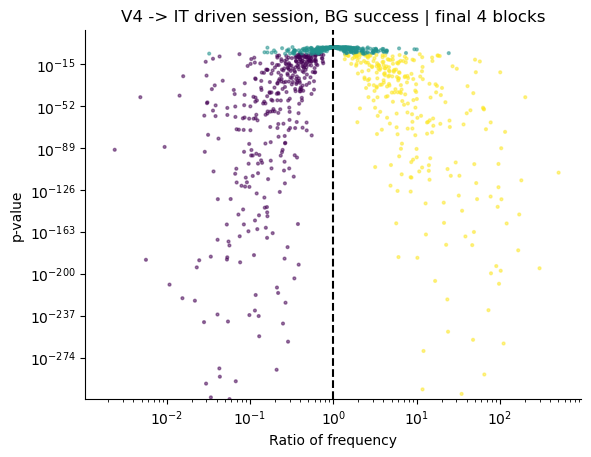

In [ ]:
chi2_df, chi2_all, p_val_all, dof_all = test_print_per_class_difference(
                      cnt_vecs["final_gen_BigGAN_V4_BGsuccess"], 
                      cnt_vecs["final_gen_BigGAN_IT_BGsuccess"])

plt.scatter(chi2_df.ratio, chi2_df.p_value, 
            c=(chi2_df.p_value < 1E-6) * (np.sign(np.log(chi2_df.ratio))), 
            s=4, alpha=0.5)
plt.axvline(1, color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Ratio of frequency")
plt.ylabel("p-value")
plt.title("V4 -> IT driven session, BG success | final 4 blocks")
plt.show()

### BigGAN fail vs BigGAN success driven by IT (initial gens)

Chi2 test p-value: 0.0e+00 chi2=18787.88 dof=999


/tmp/ipykernel_3175553/2918651089.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  "ratio": (cnt2[label]) / sum_cnt2 / (cnt1[label] / sum_cnt1),
/tmp/ipykernel_3175553/2918651089.py:39: RuntimeWarning: invalid value encountered in double_scalars
  "ratio": (cnt2[label]) / sum_cnt2 / (cnt1[label] / sum_cnt1),
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


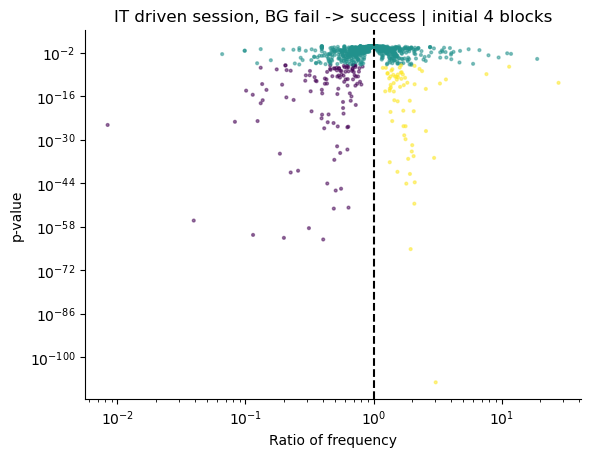

In [140]:
chi2_df, chi2_all, p_val_all, dof_all = test_print_per_class_difference(
                      cnt_vecs["init_gen_BigGAN_IT_BGfail"], 
                      cnt_vecs["init_gen_BigGAN_IT_BGsuccess"])

plt.scatter(chi2_df.ratio, chi2_df.p_value, 
            c=(chi2_df.p_value < 1E-6) * (np.sign(np.log(chi2_df.ratio))), 
            s=4, alpha=0.5)
plt.axvline(1, color='k', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Ratio of frequency")
plt.ylabel("p-value")
plt.title("IT driven session, BG fail -> success | initial 4 blocks")
plt.show()

In [ ]:
print("Most significant increased labels IT driven BG fail -> success")
chi2_df[chi2_df.ratio > 1].sort_values(by="p_value").head(25)

Most significant increased labels IT driven BG fail -> success


label         label_name        p_value         chi2  dof  cnt1  cnt2  \
342    342          wild_boar   0.000000e+00  1468.889491  1.0   970  8288   
277    277            red_fox   0.000000e+00  1768.622025  1.0   354  6353   
154    154           Pekinese   0.000000e+00  1912.433993  1.0  1043  9851   
278    278            kit_fox  3.095349e-271  1238.166737  1.0   379  5084   
682    682            obelisk  4.429378e-261  1191.436727  1.0    79  3462   
151    151          Chihuahua  7.539174e-256  1167.367543  1.0   316  4601   
116    116             chiton  1.197167e-231  1056.018664  1.0   365  4532   
157    157           papillon  4.497828e-212   965.962118  1.0    56  2765   
156    156   Blenheim_spaniel  4.993066e-196   892.149804  1.0   210  3370   
263    263           Pembroke  7.808078e-185   840.658027  1.0   233  3344   
152    152   Japanese_spaniel  9.210257e-174   789.733174  1.0   459  4209   
259    259         Pomeranian  2.847709e-155   704.696172  1.0   409  3755   
670    670      motor_scooter  3.681644e-155   704.183209  1.0   157  2620   
264    264           Cardigan  5.251725e-133   602.314852  1.0   164  2385   
144    144            pelican  3.334040e-120   543.458853  1.0   112  1979   
931    931              bagel  1.282785e-119   540.768929  1.0    67  1744   
231    231             collie  1.451325e-117   531.329247  1.0    41  1581   
249    249           malamute  4.640719e-117   529.008822  1.0   128  2019   
306    306  rhinoceros_beetle  2.306088e-114   516.615562  1.0   402  3178   
284    284        Siamese_cat  4.330213e-113   510.761615  1.0   243  2495   
69      69          trilobite  1.175152e-110   499.576599  1.0   487  3464   
533    533            dishrag  1.428497e-107   485.399310  1.0     8  1278   
343    343            warthog  6.983526e-105   473.040791  1.0   392  3007   
294    294         brown_bear  1.049118e-104   472.228541  1.0   631  3926   
777    777           scabbard  1.040044e-103   467.650444  1.0   191  2146   

         ratio  
342   3.375191  
277   7.089179  
154   3.730924  
278   5.298912  
682  17.310926  
151   5.751558  
116   4.904756  
157  19.504169  
156   6.339149  
263   5.669316  
152   3.622318  
259   3.626661  
670   6.592072  
264   5.744667  
144   6.979882  
931  10.282341  
231  15.232400  
249   6.230841  
306   3.122829  
284   4.055875  
69    2.809760  
533  63.104627  
343   3.030175  
294   2.457770  
777   4.438300

In [ ]:
print("Most significant decreased labels IT driven BG fail -> success")
chi2_df[chi2_df.ratio < 1].sort_values(by="p_value").head(25)

Most significant decreased labels IT driven BG fail -> success


label               label_name        p_value         chi2  dof  cnt1  \
467    467             butcher_shop   0.000000e+00  1933.505871  1.0  2280   
583    583               guillotine   0.000000e+00  1971.579951  1.0  1023   
298    298                 mongoose   0.000000e+00  1556.820083  1.0  2305   
360    360                    otter   0.000000e+00  2878.732560  1.0  2610   
383    383           Madagascar_cat   0.000000e+00  1665.511497  1.0  1133   
420    420                    banjo   0.000000e+00  2076.550986  1.0   950   
462    462                    broom   0.000000e+00  2190.326936  1.0  1256   
292    292                    tiger   0.000000e+00  2024.682451  1.0  1490   
836    836                 sunglass   0.000000e+00  2993.212231  1.0  2106   
967    967                 espresso   0.000000e+00  1669.334828  1.0   917   
837    837               sunglasses   0.000000e+00  4371.300555  1.0  2186   
181    181       Bedlington_terrier   0.000000e+00  3047.372160  1.0  1785   
188    188  wire-haired_fox_terrier   0.000000e+00  1783.069091  1.0  1415   
337    337                   beaver  2.724284e-310  1417.888431  1.0  2830   
175    175               otterhound  8.590999e-287  1309.751714  1.0  1194   
267    267          standard_poodle  1.334920e-270  1235.245983  1.0  1152   
265    265               toy_poodle  1.972933e-270  1234.465314  1.0  1045   
191    191                 Airedale  3.104505e-267  1219.755106  1.0  1137   
840    840                     swab  4.434701e-265  1209.839703  1.0   790   
365    365                orangutan  5.250049e-235  1071.468289  1.0  1018   
190    190         Sealyham_terrier  4.443432e-229  1044.196622  1.0   802   
289    289             snow_leopard  8.720957e-229  1042.849307  1.0   634   
286    286                   cougar  8.681326e-202   918.645375  1.0  1385   
792    792                   shovel  3.911654e-201   915.637905  1.0   709   
643    643                     mask  5.632896e-199   905.709117  1.0  1626   

     cnt2     ratio  
467  1487  0.257630  
583   160  0.061782  
298  1815  0.311047  
360  1289  0.195089  
383   360  0.125514  
420    79  0.032849  
462   271  0.085231  
292   545  0.144488  
836   715  0.134112  
967   174  0.074955  
837   298  0.053850  
181   409  0.090512  
188   582  0.162475  
337  2717  0.379248  
175   591  0.195526  
267   586  0.200940  
265   470  0.177665  
191   578  0.200811  
840   231  0.115506  
365   529  0.205271  
190   313  0.154167  
289   158  0.098444  
286  1103  0.314591  
792   280  0.156003  
643  1460  0.354693

In [ ]:
test_print_difference(cnt_vec_ITBGfail, cnt_vec_ITBGsucs, topN=20)

In [114]:
test_print_difference(cnt_vecs["final_gen_BigGAN_V4_BGfail"], 
                      cnt_vecs["final_gen_BigGAN_V4_BGsuccess"], topN=20)

Chi2 test p-value: 0.0 chi2=60588.91655997548 dof=999
Top 20 freq increased labels
1: mountain_tent 191.0 | 0->190
2: manhole_cover 161.0 | 0->160
3: minibus 138.0 | 0->137
4: mosque 115.0 | 0->114
5: snail 86.9 | 26->2345
6: barn 82.0 | 0->81
7: jeep 74.6 | 6->521
8: ladybug 62.5 | 1->124
9: tractor 58.0 | 1->115
10: maze 56.0 | 0->55
11: yurt 50.5 | 1->100
12: monastery 50.0 | 0->49
13: groenendael 47.0 | 4->234
14: slot 43.6 | 13->610
15: coil 41.9 | 12->544
16: palace 39.0 | 0->38
17: stupa 38.0 | 1->75
18: football_helmet 37.8 | 10->415
19: ambulance 34.5 | 1->68
20: dome 32.0 | 0->31

Top 20 freq decreased labels
1: frilled_lizard 0.0 | 721->8
2: harp 0.0 | 1047->18
3: common_iguana 0.0 | 297->7
4: trifle 0.0 | 121->4
5: basenji 0.1 | 65->3
6: king_penguin 0.1 | 750->52
7: proboscis_monkey 0.1 | 13->0
8: house_finch 0.1 | 23->1
9: Mexican_hairless 0.1 | 434->37
10: jaguar 0.1 | 439->38
11: Angora 0.1 | 49->4
12: Italian_greyhound 0.1 | 134->13
13: banjo 0.1 | 1251->130
14: lynx 0

In [113]:
test_print_difference(cnt_vecs["final_gen_BigGAN_IT_BGfail"], 
                      cnt_vecs["final_gen_BigGAN_IT_BGsuccess"], topN=20)

Chi2 test p-value: 0.0 chi2=127545.26638505442 dof=999
Top 20 freq increased labels
1: canoe 332.0 | 1->663
2: dishrag 142.1 | 8->1278
3: trifle 101.0 | 4->504
4: terrapin 67.0 | 3->267
5: horse_cart 65.0 | 0->64
6: golf_ball 55.7 | 5->333
7: Appenzeller 49.2 | 15->786
8: papillon 48.5 | 56->2765
9: obelisk 43.3 | 79->3462
10: ladybug 41.5 | 1->82
11: convertible 40.0 | 0->39
12: snowmobile 40.0 | 19->799
13: Shetland_sheepdog 39.5 | 31->1262
14: collie 37.7 | 41->1581
15: cauliflower 35.0 | 0->34
16: EntleBucher 34.7 | 26->935
17: bell_pepper 34.0 | 3->135
18: French_horn 34.0 | 1->67
19: custard_apple 32.3 | 5->193
20: great_grey_owl 28.8 | 7->229

Top 20 freq decreased labels
1: racket 0.0 | 41->1
2: freight_car 0.1 | 11->0
3: padlock 0.1 | 261->21
4: banjo 0.1 | 950->79
5: traffic_light 0.1 | 148->19
6: sunglasses 0.1 | 2186->298
7: screw 0.1 | 62->8
8: guillotine 0.2 | 1023->160
9: pier 0.2 | 15->2
10: espresso 0.2 | 917->174
11: dial_telephone 0.2 | 49->9
12: broom 0.2 | 1256->27

In [110]:
test_print_difference(cnt_vecs["final_gen_BigGAN_V4_BGsuccess"], 
                      cnt_vecs["final_gen_BigGAN_IT_BGsuccess"], topN=20)

Chi2 test p-value: 0.0 chi2=271329.36653621873 dof=999
Top 20 freq increased labels
1: red_fox 907.7 | 6->6353
2: kit_fox 847.5 | 5->5084
3: Persian_cat 781.0 | 1->1561
4: papillon 691.5 | 3->2765
5: Lhasa 426.2 | 5->2556
6: coyote 420.8 | 4->2103
7: hartebeest 418.0 | 3->1671
8: Shih-Tzu 318.6 | 6->2229
9: Pekinese 317.8 | 30->9851
10: Pomeranian 313.0 | 11->3755
11: Samoyed 311.0 | 1->621
12: grey_fox 283.9 | 9->2838
13: Tibetan_terrier 275.6 | 6->1928
14: warthog 273.5 | 10->3007
15: basenji 267.0 | 3->1067
16: wild_boar 259.0 | 31->8288
17: dishrag 255.8 | 4->1278
18: echidna 254.1 | 6->1778
19: Old_English_sheepdog 253.8 | 7->2029
20: chow 253.5 | 10->2787
Top 20 freq decreased labels
1: lorikeet 0.0 | 3796->23
2: garbage_truck 0.0 | 854->6
3: photocopier 0.0 | 71->0
4: police_van 0.0 | 136->1
5: trailer_truck 0.0 | 287->5
6: tow_truck 0.0 | 951->25
7: racket 0.0 | 67->1
8: trolleybus 0.0 | 29->0
9: minibus 0.0 | 137->4
10: ballplayer 0.0 | 329->11
11: fireboat 0.0 | 26->0
12: odo

In [102]:
test_print_difference(cnt_vec_V4BGsucs, cnt_vec_V4BGfail)

Chi2 test p-value: 0.0 chi2=60588.91655997548 dof=999
Top 10 freq increased labels
1: mountain_tent 191.0 | 190->0
2: manhole_cover 161.0 | 160->0
3: minibus 138.0 | 137->0
4: mosque 115.0 | 114->0
5: snail 86.9 | 2345->26
6: barn 82.0 | 81->0
7: jeep 74.6 | 521->6
8: ladybug 62.5 | 124->1
9: tractor 58.0 | 115->1
10: maze 56.0 | 55->0
Top 10 freq decreased labels
1: frilled_lizard 0.0 | 190->0
2: harp 0.0 | 160->0
3: common_iguana 0.0 | 137->0
4: trifle 0.0 | 114->0
5: basenji 0.1 | 2345->26
6: king_penguin 0.1 | 81->0
7: proboscis_monkey 0.1 | 521->6
8: house_finch 0.1 | 124->1
9: Mexican_hairless 0.1 | 115->1
10: jaguar 0.1 | 55->0


In [86]:
from scipy.stats import chi2_contingency

chi2_stat, p_value, dof, expected = chi2_contingency(np.stack(
                    [cnt_vecs["init_gen_BigGAN_IT_BGsuccess"],
                    cnt_vecs["final_gen_BigGAN_IT_BGsuccess"]])+1)

chi2_stat, p_value


(195570.491287745, 0.0)

In [91]:
chi2_stat, p_value, dof, expected = chi2_contingency(np.stack(
                    [cnt_vecs["init_gen_BigGAN_V4_BGfail"],
                     cnt_vecs["init_gen_BigGAN_V4_BGsuccess"]])+1)

chi2_stat, p_value, dof

(9030.698471507796, 0.0, 999)

In [92]:
chi2_stat, p_value, dof, expected = chi2_contingency(np.stack(
                    [cnt_vecs["final_gen_BigGAN_V4_BGfail"],
                     cnt_vecs["final_gen_BigGAN_V4_BGsuccess"]])+1)

chi2_stat, p_value, dof

(60588.91655997548, 0.0, 999)

In [90]:
chi2_stat, p_value, dof, expected = chi2_contingency(np.stack(
                    [cnt_vecs["init_gen_BigGAN_IT_BGfail"],
                     cnt_vecs["init_gen_BigGAN_IT_BGsuccess"]])+1)

chi2_stat, p_value, dof

(18787.880618839496, 0.0, 999)

In [89]:
chi2_stat, p_value, dof, expected = chi2_contingency(np.stack(
                    [cnt_vecs["final_gen_BigGAN_IT_BGfail"],
                     cnt_vecs["final_gen_BigGAN_IT_BGsuccess"]])+1)

chi2_stat, p_value, dof

(127545.26638505442, 0.0)

In [88]:
expected

array([[  6.52619208, 162.8710544 ,  43.12961719, ...,  65.82941572,
         16.17360645, 159.7498321 ],
       [ 16.47380792, 411.1289456 , 108.87038281, ..., 166.17058428,
         40.82639355, 403.2501679 ]])

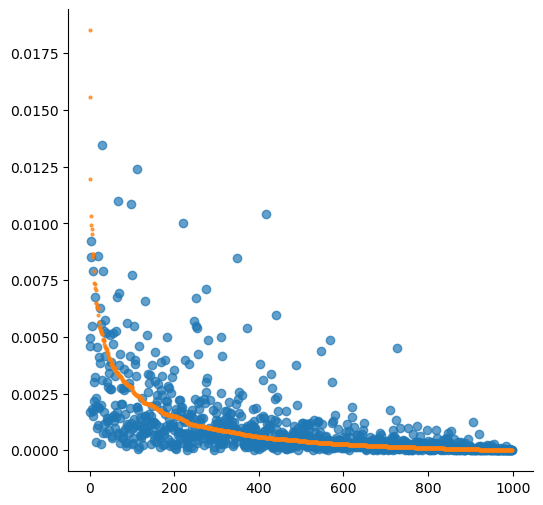

In [76]:
sortidx = np.argsort(freq_vecs["final_gen_BigGAN_IT_BGsuccess"])[::-1]
plt.figure(figsize=[6,6])
plt.plot(freq_vecs["final_gen_BigGAN_IT_BGfail"][sortidx], "o", 
         label="IT BG fail", alpha=0.7)
plt.plot(freq_vecs["final_gen_BigGAN_IT_BGsuccess"][sortidx], "o",markersize=2,
         label="IT BG success", alpha=0.7)
plt.show()

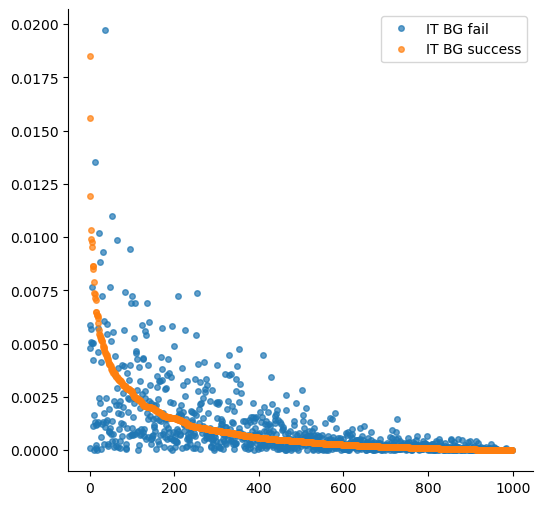

In [79]:
sortidx = np.argsort(freq_vecs["final_gen_BigGAN_IT_BGsuccess"])[::-1]
plt.figure(figsize=[6,6])
plt.plot(freq_vecs["init_gen_BigGAN_IT_BGsuccess"][sortidx], "o", markersize=4,
         label="IT BG fail", alpha=0.7)
plt.plot(freq_vecs["final_gen_BigGAN_IT_BGsuccess"][sortidx], "o", markersize=4,
         label="IT BG success", alpha=0.7)
plt.legend()
plt.show()

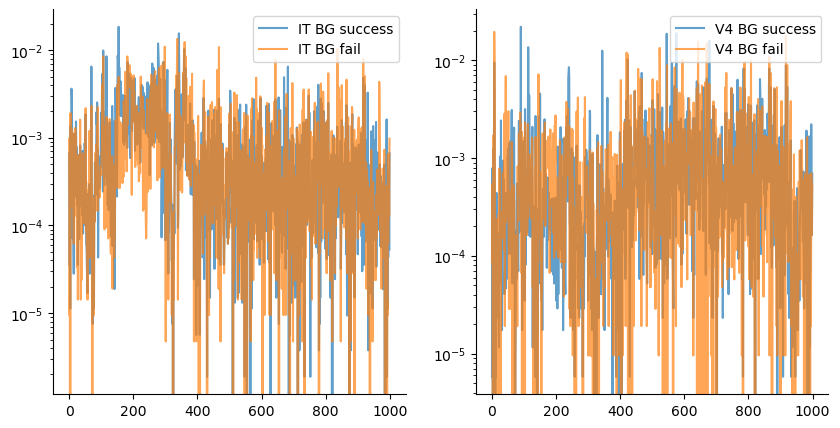

In [64]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.plot(cnt_vec_ITBGsucs/cnt_vec_ITBGsucs.sum(), label="IT BG success", alpha=0.7)
plt.plot(cnt_vec_ITBGfail/cnt_vec_ITBGfail.sum(), label="IT BG fail", alpha=0.7)
plt.yscale('log')
plt.legend()
plt.subplot(122)
plt.plot(cnt_vec_V4BGsucs/cnt_vec_V4BGsucs.sum(), label="V4 BG success", alpha=0.7)
plt.plot(cnt_vec_V4BGfail/cnt_vec_V4BGfail.sum(), label="V4 BG fail", alpha=0.7)
plt.yscale('log')
plt.legend()
plt.show()

In [24]:
stats_df_all[init_gen_mask][["kNNcoslabel_1_imagenet_valid"]].\
    value_counts()#.unstack(fill_value=0)

kNNcoslabel_1_imagenet_valid
917                             5902
921                             2616
539                             1715
794                             1093
611                             1071
                                ... 
425                                1
417                                1
115                                1
825                                1
90                                 1
Name: count, Length: 849, dtype: int64

In [26]:
knn_coslabels_init = stats_df_all[init_gen_mask & BigGAN_mask & IT_mask][[f"kNNcoslabel_{i}_imagenet_valid" 
                                             for i in range(50)]].to_numpy()
knn_coslabels_end = stats_df_all[final_gen_mask & BigGAN_mask & IT_mask][[f"kNNcoslabel_{i}_imagenet_valid" 
                                             for i in range(50)]].to_numpy()

In [28]:
labels_init, counts_init = np.unique(knn_coslabels_init, return_counts=True)
labels_end, counts_end = np.unique(knn_coslabels_end, return_counts=True)

In [30]:
print_labels_counts(labels_init, counts_init, label_dict=label_dict, topk=30)

Mexican_hairless: 10865
Border_terrier: 7591
malinois: 5873
wallaby: 5605
comic_book: 5440
Irish_terrier: 5389
seat_belt: 5371
hog: 4872
butcher_shop: 4758
grey_fox: 4525
book_jacket: 4441
mask: 4384
Airedale: 4313
German_shepherd: 4093
standard_schnauzer: 3942
sea_lion: 3817
miniature_pinscher: 3746
hatchet: 3646
punching_bag: 3626
dhole: 3490
sombrero: 3477
wild_boar: 3382
Australian_terrier: 3338
armadillo: 3281
Lakeland_terrier: 3254
miniature_schnauzer: 3244
wire-haired_fox_terrier: 3224
vizsla: 3173
Weimaraner: 3163
Rhodesian_ridgeback: 3134


In [50]:
sum(counts_end)

742500

In [51]:
sum(counts_init)

593800

In [33]:
max(labels_end)

999

In [34]:
min(labels_end)

0

In [38]:
# import numpy as np
cnt_vec_end= np.zeros(1000, dtype=int)
cnt_vec_end[labels_end] = counts_end
cnt_vec_init = np.zeros(1000, dtype=int)
cnt_vec_init[labels_init] = counts_init

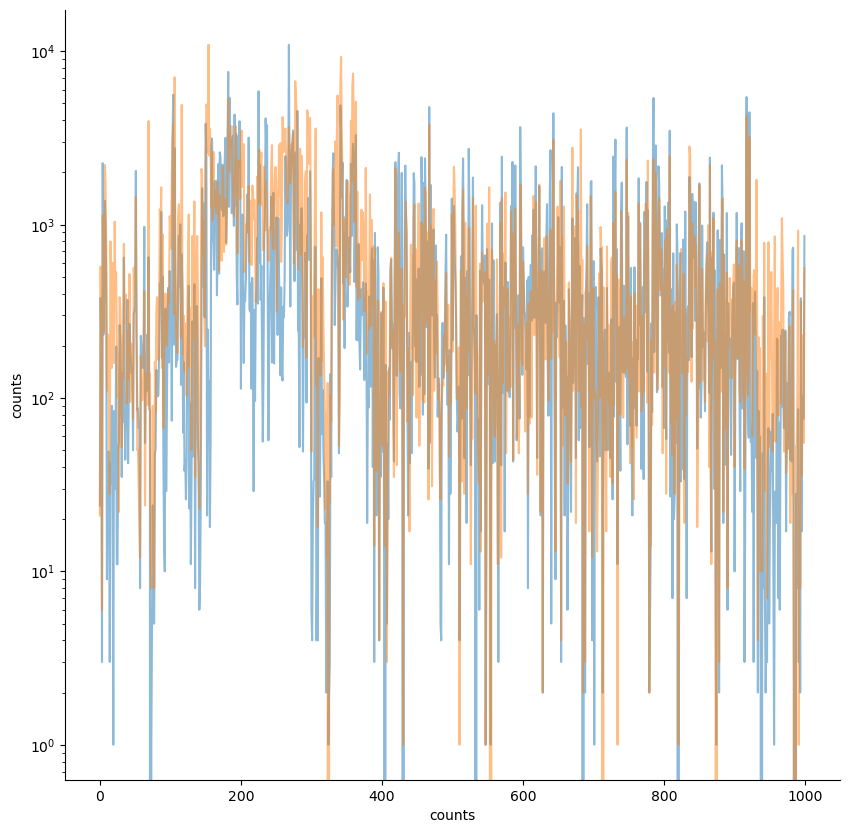

In [42]:
plt.figure(figsize=(10, 10))
plt.plot(cnt_vec_init, label="Initial", alpha=0.5)
plt.plot(cnt_vec_end, label="Final", alpha=0.5)
plt.xlabel("counts")
plt.ylabel("counts")
# plt.xscale("log")
plt.yscale("log")
plt.show()

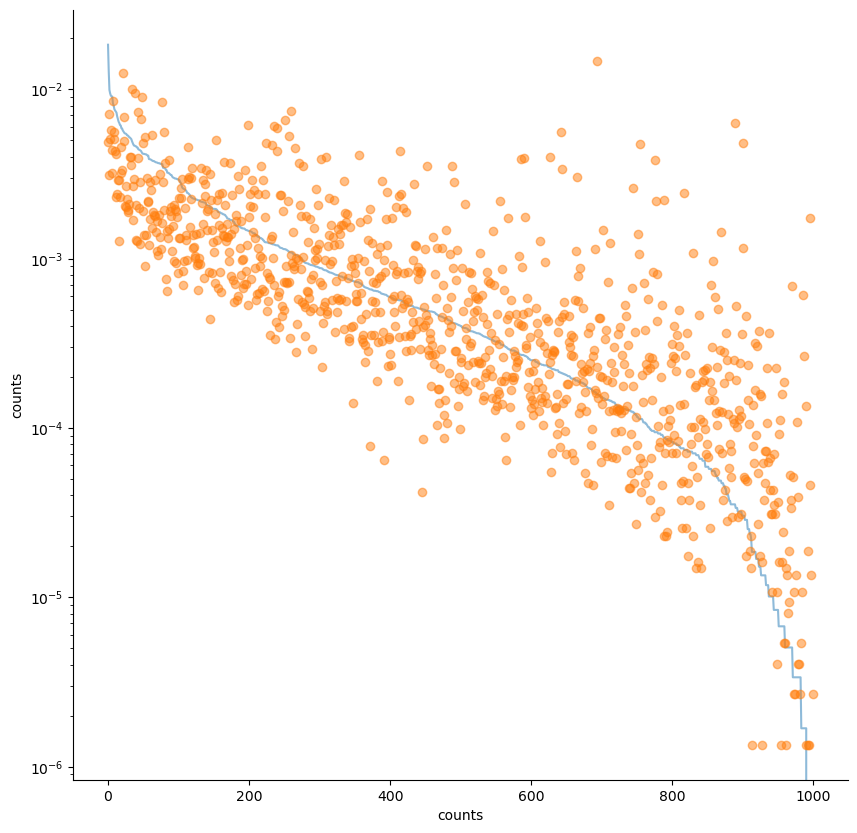

In [48]:
plt.figure(figsize=(10, 10))
arg_idx = np.argsort(-cnt_vec_init)
plt.plot(cnt_vec_init[arg_idx]/cnt_vec_init.sum(), label="Initial", alpha=0.5)
plt.plot(cnt_vec_end[arg_idx]/cnt_vec_end.sum(), "o", label="Final", alpha=0.5)
plt.xlabel("counts")
plt.ylabel("counts")
# plt.xscale("log")
plt.yscale("log")
plt.show()

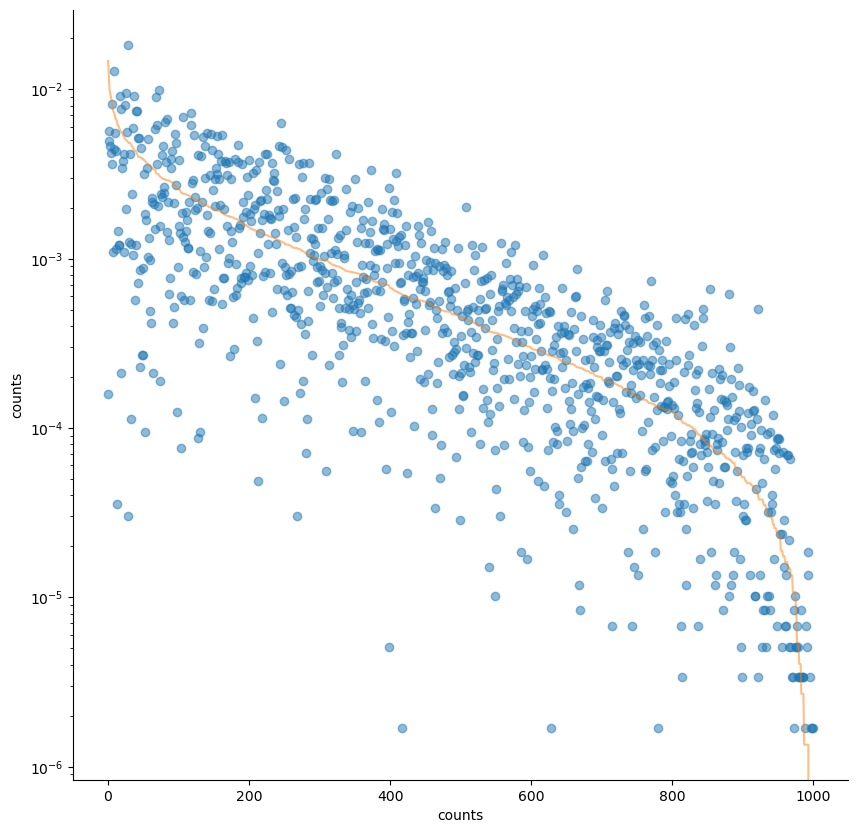

In [52]:
plt.figure(figsize=(10, 10))
arg_idx = np.argsort(-cnt_vec_end)
plt.plot(cnt_vec_init[arg_idx] / cnt_vec_init.sum(), "o", label="Initial", alpha=0.5)
plt.plot(cnt_vec_end[arg_idx] / cnt_vec_end.sum(), label="Final", alpha=0.5)
plt.xlabel("counts")
plt.ylabel("counts")
# plt.xscale("log")
plt.yscale("log")
plt.show()

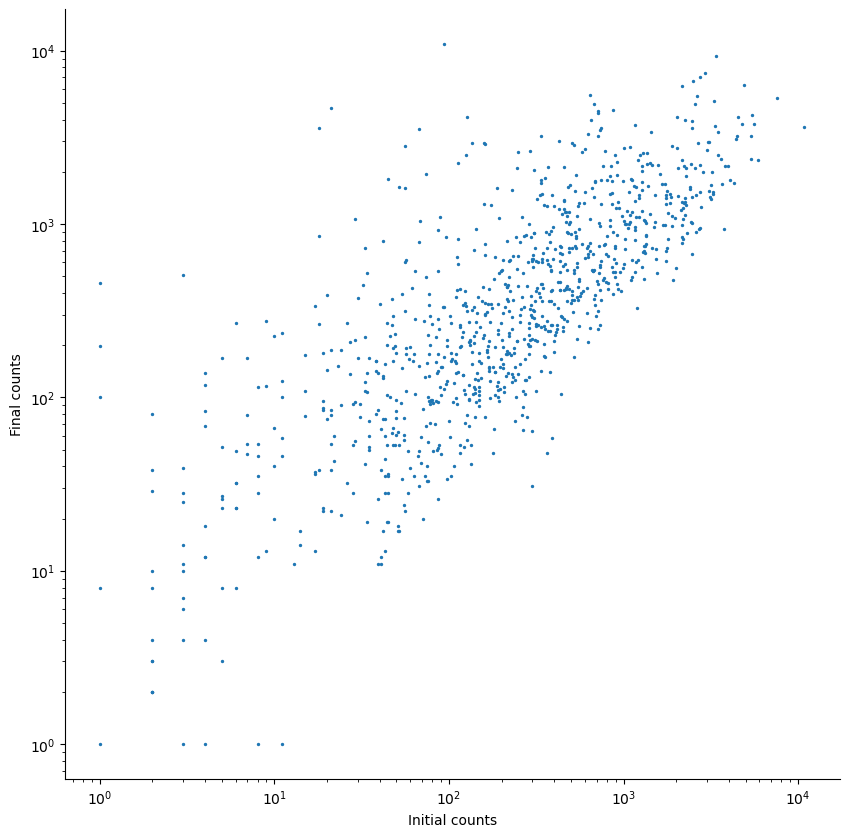

In [39]:
plt.figure(figsize=(10, 10))
plt.scatter(cnt_vec_init, cnt_vec_end, s=2)
plt.xlabel("Initial counts")
plt.ylabel("Final counts")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [58]:
print_labels_counts(labels_end, counts_end, label_dict=label_dict, topk=30)

Pekinese, Pekingese, Peke: 10894
wild boar, boar, Sus scrofa: 9258
black-footed ferret, ferret, Mustela nigripes: 7436
wombat: 7074
red fox, Vulpes vulpes: 6707
hog, pig, grunter, squealer, Sus scrofa: 6349
polecat, fitch, foulmart, foumart, Mustela putorius: 6250
beaver: 5547
kit fox, Vulpes macrotis: 5463
Border terrier: 5317
armadillo: 5112
Chihuahua: 4917
chiton, coat-of-mail shell, sea cradle, polyplacophore: 4897
Japanese spaniel: 4668
brown bear, bruin, Ursus arctos: 4557
Arctic fox, white fox, Alopex lagopus: 4490
American black bear, black bear, Ursus americanus, Euarctos americanus: 4351
comic book: 4256
Pomeranian: 4164
grey fox, gray fox, Urocyon cinereoargenteus: 4159
mongoose: 4120
weasel: 3964
trilobite: 3951
otter: 3899
butcher shop, meat market: 3767
wallaby, brush kangaroo: 3757
Yorkshire terrier: 3703
Australian terrier: 3685
Mexican hairless: 3644
rhinoceros beetle: 3580


In [48]:
label_dict = label_descr_dict
sorted_indices = np.argsort(-counts_init)
sorted_labels = labels_init[sorted_indices]
sorted_counts = counts_init[sorted_indices]

for label, count in zip(sorted_labels[:30], sorted_counts[:30]):
    label_name = label_dict[label]
    print(f"{label_name}: {count}")

comic book: 164725
book jacket, dust cover, dust jacket, dust wrapper: 132870
web site, website, internet site, site: 75045
shower curtain: 32544
jigsaw puzzle: 29650
mask: 29037
doormat, welcome mat: 24758
miniskirt, mini: 23411
envelope: 21114
feather boa, boa: 20361
paintbrush: 19334
tray: 19051
knee pad: 18490
vase: 18136
plastic bag: 17867
binder, ring-binder: 16186
sombrero: 14475
sunglass: 14122
velvet: 13882
Mexican hairless: 13716
loupe, jeweler's loupe: 12483
electric ray, crampfish, numbfish, torpedo: 12343
nipple: 11834
toilet seat: 11830
umbrella: 11752
gasmask, respirator, gas helmet: 11620
hair spray: 11551
saltshaker, salt shaker: 10411
seat belt, seatbelt: 10255
butcher shop, meat market: 10146
